In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt 
import seaborn as sns

plt.rc('font', family='NanumBarunGothic')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def create_df():

  #연도별 데이터 경로
  HTS_dir = '/content/drive/MyDrive/bigcontest/제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_HTS'
  Player_dir = '/content/drive/MyDrive/bigcontest/제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_선수'
  Hitter_dir = '/content/drive/MyDrive/bigcontest/제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_타자 기본'
  #단일 데이터 경로
  Team_dir = '/content/drive/MyDrive/bigcontest/제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_팀.csv'
  Schedule_dir = '/content/drive/MyDrive/bigcontest/제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_경기일정_2021.csv'
  val_dir = '/content/drive/MyDrive/bigcontest/평가데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_평가데이터.xlsx'

  year = [2018, 2019, 2020, 2021]

  for i in year:
    globals()['HTS_{}'.format(i)]     = pd.read_csv(HTS_dir + '_' + str(i) + '.csv', encoding='CP949')
    globals()['Player_{}'.format(i)]  = pd.read_csv(Player_dir + '_' + str(i) + '.csv', encoding='CP949')
    globals()['Hitter_{}'.format(i)]  = pd.read_csv(Hitter_dir + '_' + str(i) + '.csv', encoding='CP949')

  global Team_df, Schedule_df, val_df
  Team_df = pd.read_csv(Team_dir, encoding='CP949')
  Schedule_df = pd.read_csv(Schedule_dir, encoding='CP949')
  val_df = pd.read_excel(val_dir)

######################

#연도별 데이터 하나로 통합
def concat_df():
  df_list = ['HTS', 'Player', 'Hitter']

#각 칼럼이 모두 같은지 검사 후 통합
  for i in df_list:
    if ((globals()['{}_2018'.format(i)].columns == globals()['{}_2019'.format(i)].columns).all()) and ((globals()['{}_2019'.format(i)].columns == globals()['{}_2020'.format(i)].columns).all()) and \
    ((globals()['{}_2020'.format(i)].columns == globals()['{}_2021'.format(i)].columns).all()):
      globals()['{}_df'.format(i)] = pd.concat( [ globals()['{}_2018'.format(i)], globals()['{}_2019'.format(i)], globals()['{}_2020'.format(i)], globals()['{}_2021'.format(i) ] ] )

#연도별 길이의 합이 통합된 데이터의 길이와 같은지 검사
  for i in df_list:
    if len(globals()['{}_2018'.format(i)]) + len(globals()['{}_2019'.format(i)]) + len(globals()['{}_2020'.format(i)]) + len(globals()['{}_2021'.format(i)]) == len(globals()['{}_df'.format(i)]):
      print('{} is complete!'.format(i))

######################

create_df()
concat_df()

HTS is complete!
Player is complete!
Hitter is complete!


In [ ]:
df_2018 = pd.read_csv('/content/drive/MyDrive/bigcontest/add_hts_2018.csv', encoding='CP949')
df_2019 = pd.read_csv('/content/drive/MyDrive/bigcontest/add_hts_2019.csv', encoding='CP949')
df_2020 = pd.read_csv('/content/drive/MyDrive/bigcontest/add_hts_2020.csv', encoding='CP949')
df_2021 = pd.read_csv('/content/drive/MyDrive/bigcontest/new_add_hts_2021.csv')

In [ ]:
df_2021 = df_2021.iloc[:, 1:]

### **Data split function**

In [ ]:
# 공백기간 삭제 함수

def del_empty(df):
    before = df[df['DATE'] < 20210801].reset_index(drop=True)
    tmp = df[df['DATE'] >= 20210810].reset_index(drop=True)

    date_list = []
    for i in range(len(tmp)):
        date = datetime.datetime.strptime(str(tmp['DATE'][i]), '%Y%m%d')
        date = date + datetime.timedelta(days=-28)
        date = date.strftime('%Y%m%d')
        date_list.append(int(date))

    tmp['DATE'] = date_list

    new_df = pd.concat([before, tmp])
    
    return new_df

In [ ]:
df_2021 = del_empty(df_2021)

In [ ]:
# 홈 원정 분할 생성 함수

def HA_split(df, period, interval, del_cri):
    
    first_date = df.sort_values('DATE').reset_index(drop=True).loc[0,'DATE']

    last_date = df.sort_values('DATE').reset_index(drop=True).loc[len(df)-1, 'DATE']
    print('개막 날짜 : {}, 마지막 날짜 : {}'.format(first_date, last_date))

    # 결과값 저장할 데이터프레임 생성
    home_split = pd.DataFrame()
    away_split = pd.DataFrame()

    while True:
        
        start_date = str(first_date)

        end_date = datetime.datetime.strptime(start_date, '%Y%m%d')
        end_date = end_date + datetime.timedelta(days=period)
        end_date = end_date.strftime('%Y%m%d')

        pred_date = datetime.datetime.strptime(end_date, '%Y%m%d')
        pred_date = pred_date + datetime.timedelta(days=24)
        pred_date = pred_date.strftime('%Y%m%d')

        if int(pred_date) >= last_date:
            print('가져오는 날짜{}가 마지막 날짜{} 이후의 데이터입니다.'.format(pred_date, last_date))
            break

        # 해당 시즌 타자 목록 (name -> pcode)
        hitter_list = list(set(df['PCODE']))

        # 더해줄 칼럼 목록 (avg, obp, slg, ops, avLI, RE24 제외)
        target_col = ['ab', 'score', 'hit', '2_hit', '3_hit', 'homerun', 'tb', 'rbi', 'sb', 'cs', 'bb', 'hpp', 'ibb', 'so', 'gdp', 'sh', 'sf', 'pitch', 'WPA', 'power_barrel', 'contact_barrel', 'clutch_barrel']

        # start_date 이후의 경기만 추출
        tr_df = df[ (df['DATE'] >= int(start_date)) & (df['DATE'] <= int(end_date)) ]
        ts_df = df[ (df['DATE'] > int(end_date)) & (df['DATE'] <= int(pred_date)) ]

        # first_date + interval
        first_date = datetime.datetime.strptime(start_date, '%Y%m%d')
        first_date = first_date + datetime.timedelta(days=interval)
        first_date = first_date.strftime('%Y%m%d')

        # 타자 한명씩 추출
        for player in hitter_list:

            tr_pl_data = tr_df[tr_df['PCODE'] == player]
            ts_pl_data = ts_df[ts_df['PCODE'] == player]

            away_tr = tr_pl_data[ tr_pl_data['vs'].str.contains('@') ]
            home_tr = tr_pl_data[ tr_pl_data['vs'].str.contains('@')  == False ]

            away_ts = ts_pl_data[ ts_pl_data['vs'].str.contains('@') ]
            home_ts = ts_pl_data[ ts_pl_data['vs'].str.contains('@')  == False ]

            if (len(away_tr) < del_cri) | (len(home_tr) < del_cri) | (len(away_ts) < 3.5) | (len(home_ts) < 3.5) :
                continue

            else:

                # tr_data의 타겟 칼럼을 모두 합해서 저장
                home_sum = home_tr.loc[:, target_col].sum()
                away_sum = away_tr.loc[:, target_col].sum()
                # 어떤 선수인지 저장 (name -> pcode)
                home_sum['PCODE'] = player
                away_sum['PCODE'] = player

                home_sum['NAME'] = tr_pl_data.iloc[0,0]
                away_sum['NAME'] = tr_pl_data.iloc[0,0]

                # ts_data의 성적들로 avg, slg, obp, ops 라벨 생성
                home_ts_sum = home_ts.loc[:, target_col].sum()
                away_ts_sum = away_ts.loc[:, target_col].sum()

                home_sum['avg_label'] = home_ts_sum['hit'] / home_ts_sum['ab'] if home_ts_sum['ab'] != 0 else 0
                home_sum['slg_label'] = home_ts_sum['tb'] / home_ts_sum['ab'] if home_ts_sum['ab'] != 0 else 0
                home_sum['obp_label'] = (home_ts_sum['hit'] + home_ts_sum['bb'] + home_ts_sum['hpp']) / (home_ts_sum['ab'] +  home_ts_sum['bb'] + home_ts_sum['hpp'] + home_ts_sum['sf'])
                home_sum['ops_label'] = home_sum['slg_label'] + home_sum['obp_label']

                away_sum['avg_label'] = away_ts_sum['hit'] / away_ts_sum['ab'] if away_ts_sum['ab'] != 0 else 0
                away_sum['slg_label'] = away_ts_sum['tb'] / away_ts_sum['ab'] if away_ts_sum['ab'] != 0 else 0
                away_sum['obp_label'] = (away_ts_sum['hit'] + away_ts_sum['bb'] + away_ts_sum['hpp']) / (away_ts_sum['ab'] +  away_ts_sum['bb'] + away_ts_sum['hpp'] + away_ts_sum['sf'])
                away_sum['ops_label'] = away_sum['slg_label'] + away_sum['obp_label']

                # Series 데이터를 DataFrame 형식으로 변환
                home_result = home_sum.to_frame().transpose()
                away_result = away_sum.to_frame().transpose()
                    
                # 이 선수 데이터를 전체 데이터셋에 추가
                home_split = pd.concat([home_split, home_result])
                away_split = pd.concat([away_split, away_result])
            
    # 데이터셋 인덱스 초기화
    home_split = home_split.reset_index(drop=True)
    away_split = away_split.reset_index(drop=True)
            
    return home_split, away_split

In [ ]:
# 홈 원정 구분하지 않은 생성 함수

def total_split(df, period, interval, del_cri):

    first_date = df.sort_values('DATE').reset_index(drop=True).loc[0,'DATE']

    last_date = df.sort_values('DATE').reset_index(drop=True).loc[len(df)-1, 'DATE']
    print('개막 날짜 : {}, 마지막 날짜 : {}'.format(first_date, last_date))

    # 결과값 저장할 데이터프레임 생성
    total_split = pd.DataFrame()

    while True:
        
        start_date = str(first_date)

        end_date = datetime.datetime.strptime(start_date, '%Y%m%d')
        end_date = end_date + datetime.timedelta(days=period)
        end_date = end_date.strftime('%Y%m%d')

        pred_date = datetime.datetime.strptime(end_date, '%Y%m%d')
        pred_date = pred_date + datetime.timedelta(days=24)
        pred_date = pred_date.strftime('%Y%m%d')

        if int(pred_date) >= last_date:
            print('가져오는 날짜{}가 마지막 날짜{} 이후의 데이터입니다.'.format(pred_date, last_date))
            break

        # 해당 시즌 타자 목록 (name -> pcode)
        hitter_list = list(set(df['PCODE']))

        # 더해줄 칼럼 목록 (avg, obp, slg, ops, avLI, RE24 제외)
        target_col = ['ab', 'score', 'hit', '2_hit', '3_hit', 'homerun', 'tb', 'rbi', 'sb', 'cs', 'bb', 'hpp', 'ibb', 'so', 'gdp', 'sh', 'sf', 'pitch', 'WPA', 'power_barrel', 'contact_barrel', 'clutch_barrel']

        # start_date 이후의 경기만 추출
        tr_df = df[ (df['DATE'] >= int(start_date)) & (df['DATE'] <= int(end_date)) ]
        ts_df = df[ (df['DATE'] > int(end_date)) & (df['DATE'] <= int(pred_date)) ]

        # first_date + interval
        first_date = datetime.datetime.strptime(start_date, '%Y%m%d')
        first_date = first_date + datetime.timedelta(days=interval)
        first_date = first_date.strftime('%Y%m%d')

        # 타자 한명씩 추출
        for player in hitter_list:

            tr_pl_data = tr_df[tr_df['PCODE'] == player]
            ts_pl_data = ts_df[ts_df['PCODE'] == player]

            if (len(tr_pl_data) < del_cri) | (len(ts_pl_data) < 3.5) :
                continue

            else:
                # tr_data의 타겟 칼럼을 모두 합해서 저장
                tr_sum = tr_pl_data.loc[:, target_col].sum()

                # 어떤 선수인지 저장 (name -> pcode)
                tr_sum['PCODE'] = player
                tr_sum['NAME'] = tr_pl_data.iloc[0,0]

                # ts_data의 성적들로 avg, slg, obp, ops 라벨 생성
                ts_sum = ts_pl_data.loc[:, target_col].sum()

                tr_sum['avg_label'] = ts_sum['hit'] / ts_sum['ab'] if ts_sum['ab'] != 0 else 0
                tr_sum['slg_label'] = ts_sum['tb'] / ts_sum['ab'] if ts_sum['ab'] != 0 else 0
                tr_sum['obp_label'] = (ts_sum['hit'] + ts_sum['bb'] + ts_sum['hpp']) / (ts_sum['ab'] +  ts_sum['bb'] + ts_sum['hpp'] + ts_sum['sf'])
                tr_sum['ops_label'] = tr_sum['slg_label'] + tr_sum['obp_label']

                # Series 데이터를 DataFrame 형식으로 변환
                tmp_result = tr_sum.to_frame().transpose()
                    
                # 이 선수 데이터를 전체 데이터셋에 추가
                total_split = pd.concat([total_split, tmp_result])
            
    # 데이터셋 인덱스 초기화
    total_split = total_split.reset_index(drop=True)
            
    return total_split

In [ ]:
# 결과 도출용 데이터셋 생성

def HA_final(df, period):

    # 결과값 저장할 데이터프레임 생성
    home_split = pd.DataFrame()
    away_split = pd.DataFrame()

    start_date = datetime.datetime.strptime('20210815', '%Y%m%d')
    start_date = start_date + datetime.timedelta(days=-period)
    start_date = start_date.strftime('%Y%m%d')

    # 해당 시즌 타자 목록 (name -> pcode)
    hitter_list = list(set(df['PCODE']))

    # 더해줄 칼럼 목록 (avg, obp, slg, ops, avLI, RE24 제외)
    target_col = ['ab', 'score', 'hit', '2_hit', '3_hit', 'homerun', 'tb', 'rbi', 'sb', 'cs', 'bb', 'hpp', 'ibb', 'so', 'gdp', 'sh', 'sf', 'pitch', 'WPA', 'power_barrel', 'contact_barrel', 'clutch_barrel']

    # start_date 이후의 경기만 추출
    final_df = df[ (df['DATE'] >= int(start_date)) ]

    # 타자 한명씩 추출
    for player in hitter_list:

        final_pl_df = final_df[final_df['PCODE'] == player]
        if (len(final_pl_df) < 1) :
          continue

        else:
          away_pl = final_pl_df[ final_pl_df['vs'].str.contains('@') ]
          home_pl = final_pl_df[ final_pl_df['vs'].str.contains('@')  == False ]

          # tr_data의 타겟 칼럼을 모두 합해서 저장
          home_sum = home_pl.loc[:, target_col].sum()
          away_sum = away_pl.loc[:, target_col].sum()
          # 어떤 선수인지 저장 (name -> pcode)
          home_sum['PCODE'] = player
          away_sum['PCODE'] = player

          home_sum['NAME'] = final_pl_df.iloc[0,0]
          away_sum['NAME'] = final_pl_df.iloc[0,0]

          # Series 데이터를 DataFrame 형식으로 변환
          home_result = home_sum.to_frame().transpose()
          away_result = away_sum.to_frame().transpose()
              
          # 이 선수 데이터를 전체 데이터셋에 추가
          home_split = pd.concat([home_split, home_result])
          away_split = pd.concat([away_split, away_result])
            
    # 데이터셋 인덱스 초기화
    home_split = home_split.reset_index(drop=True)
    away_split = away_split.reset_index(drop=True)
            
    return home_split, away_split

In [ ]:
# 결과 도출용 데이터셋 생성

def total_final(df, period):

    # 결과값 저장할 데이터프레임 생성
    total_split = pd.DataFrame()

    start_date = datetime.datetime.strptime('20210815', '%Y%m%d')
    start_date = start_date + datetime.timedelta(days=-period)
    start_date = start_date.strftime('%Y%m%d')

    # 해당 시즌 타자 목록 (name -> pcode)
    hitter_list = list(set(df['PCODE']))

    # 더해줄 칼럼 목록 (avg, obp, slg, ops, avLI, RE24 제외)
    target_col = ['ab', 'score', 'hit', '2_hit', '3_hit', 'homerun', 'tb', 'rbi', 'sb', 'cs', 'bb', 'hpp', 'ibb', 'so', 'gdp', 'sh', 'sf', 'pitch', 'WPA', 'power_barrel', 'contact_barrel', 'clutch_barrel']

    # start_date 이후의 경기만 추출
    final_df = df[ (df['DATE'] >= int(start_date)) ]

    # 타자 한명씩 추출
    for player in hitter_list:

        final_pl_df = final_df[final_df['PCODE'] == player]
        if (len(final_pl_df) < 1) :
          continue

        else:
          # tr_data의 타겟 칼럼을 모두 합해서 저장
          total_sum = final_pl_df.loc[:, target_col].sum()

          # 어떤 선수인지 저장 (name -> pcode)
          total_sum['PCODE'] = player


          total_sum['NAME'] = final_pl_df.iloc[0,0]

          # Series 데이터를 DataFrame 형식으로 변환
          total_result = total_sum.to_frame().transpose()
              
          # 이 선수 데이터를 전체 데이터셋에 추가
          total_split = pd.concat([total_split, total_result])
            
    # 데이터셋 인덱스 초기화
    total_split = total_split.reset_index(drop=True)
            
    return total_split

### **Data split**

In [ ]:
# 홈/원정 나눈 데이터

In [ ]:
home_2018, away_2018 = HA_split(df_2018, period = 70, interval = 7, del_cri= 5)

개막 날짜 : 20180324, 마지막 날짜 : 20181014
가져오는 날짜20181016가 마지막 날짜20181014 이후의 데이터입니다.


In [ ]:
home_2019, away_2019 = HA_split(df_2019, period = 70, interval = 7, del_cri= 5)

개막 날짜 : 20190323, 마지막 날짜 : 20191001
가져오는 날짜20191001가 마지막 날짜20191001 이후의 데이터입니다.


In [ ]:
home_2020, away_2020 = HA_split(df_2020, period = 70, interval = 7, del_cri= 5)

개막 날짜 : 20200505, 마지막 날짜 : 20201031
가져오는 날짜20201106가 마지막 날짜20201031 이후의 데이터입니다.


In [ ]:
home_2021, away_2021 = HA_split(df_2021, period = 70, interval = 7, del_cri= 5)

개막 날짜 : 20210403, 마지막 날짜 : 20210815


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in double_scalars


가져오는 날짜20210817가 마지막 날짜20210815 이후의 데이터입니다.


In [ ]:
len(home_2018), len(home_2019), len(home_2020), len(home_2021)

(1100, 1060, 1194, 579)

In [ ]:
# 전체 시즌 데이터

In [ ]:
total_2018 = total_split(df_2018, period = 70, interval = 7, del_cri= 10)

개막 날짜 : 20180324, 마지막 날짜 : 20181014
가져오는 날짜20181016가 마지막 날짜20181014 이후의 데이터입니다.


In [ ]:
total_2019 = total_split(df_2019, period = 70, interval = 7, del_cri= 10)

개막 날짜 : 20190323, 마지막 날짜 : 20191001
가져오는 날짜20191001가 마지막 날짜20191001 이후의 데이터입니다.


In [ ]:
total_2020 = total_split(df_2020, period = 70, interval = 7, del_cri= 10)

개막 날짜 : 20200505, 마지막 날짜 : 20201031
가져오는 날짜20201106가 마지막 날짜20201031 이후의 데이터입니다.


In [ ]:
total_2021 = total_split(df_2021, period = 70, interval = 7, del_cri= 10)

개막 날짜 : 20210403, 마지막 날짜 : 20210815


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars


가져오는 날짜20210817가 마지막 날짜20210815 이후의 데이터입니다.


In [ ]:
len(total_2018), len(total_2019), len(total_2020), len(total_2021)

(1824, 1558, 1636, 810)

### **Pre-processing**

In [ ]:
#전처리 코드 다 합친 것(원본 유지)
def cal_feature(data):

    new_data = data.copy()

    new_data['avg'] = new_data.apply(lambda x: round(x['hit'] / x['ab'], 3) if x['ab'] != 0 else 0, axis=1)
    new_data['obp'] = new_data.apply(lambda x: round((x['hit'] + x['bb'] + x['hpp']) / (x['ab'] + x['bb'] + x['hpp'] + x['sf']), 3) if (x['ab'] + x['bb'] + x['hpp'] + x['sf']) != 0 else 0, axis=1)
    new_data['slg'] = new_data.apply(lambda x: round(x['tb'] / x['ab'], 3) if x['ab'] != 0 else 0, axis=1)
    new_data['ops'] = new_data['obp'] + new_data['slg']
    new_data['pa'] = new_data['ab'] + new_data['bb'] + new_data['sf']
    new_data['1_hit'] = new_data['hit'] - new_data['2_hit'] - new_data['3_hit'] - new_data['homerun']
    new_data['xh'] = new_data['2_hit'] + new_data['3_hit'] + new_data['homerun']


    new_data['babib'] = new_data.apply(lambda x: round((x['hit'] - x['homerun']) / (x['ab'] - x['so'] - x['homerun'] + x['sf']), 3) if (x['ab'] - x['so'] - x['homerun'] + x['sf']) != 0 else 0, axis=1)
    new_data['pitch/pa'] = new_data.apply(lambda x: round(x['pitch'] / x['pa'], 2) if x['pa'] != 0 else 0, axis=1)
    new_data['cq'] = new_data.apply(lambda x: round((0.5 * x['hit'] + 0.3 * x['tb']) / (x['ab'] - x['so']), 3) if (x['ab'] - x['so']) != 0 else 0, axis=1)
    new_data['b/k'] = new_data.apply(lambda x: round(x['bb'] / x['so'], 3) if x['so'] != 0 else 0, axis=1)
    new_data['IsoP'] = new_data['slg'] - new_data['avg']
    new_data['IsoD'] = new_data['obp'] - new_data['avg']
    new_data['psn'] = new_data.apply(lambda x: round((2 * x['homerun'] * x['sb']) / (x['homerun'] + x['sb']), 3) if (x['homerun'] + x['sb']) != 0 else 0, axis=1)
    new_data['hr%'] = new_data.apply(lambda x: round(x['homerun'] / x['pa'], 3) if x['pa'] != 0 else 0, axis=1)
    new_data['kk%'] = new_data.apply(lambda x: round(x['so'] / x['pa'], 3) if x['pa'] != 0 else 0, axis=1)
    new_data['bb%'] = new_data.apply(lambda x: round(x['bb'] / x['pa'], 3) if x['pa'] != 0 else 0, axis=1)
    new_data['xh/ab'] = new_data.apply(lambda x: round(x['xh'] / x['pa'], 3) if x['pa'] != 0 else 0, axis=1)
    new_data['xh/h'] = new_data.apply(lambda x: round(x['xh'] / x['hit'], 3) if x['hit'] != 0 else 0, axis=1)
    new_data['hr/xh'] = new_data.apply(lambda x: round(x['homerun'] / x['xh'], 3) if x['xh'] != 0 else 0, axis=1)
    new_data['pa/hr'] = new_data.apply(lambda x: round(x['pa'] / x['homerun'], 3) if x['homerun'] != 0 else 0, axis=1)
    new_data['ab/hr'] = new_data.apply(lambda x: round(x['ab'] / x['homerun'], 3) if x['homerun'] != 0 else 0, axis=1)
    new_data['ueqr'] = new_data.apply(lambda x: round((x['hit'] + x['tb'] + 1.5*(x['bb'] + x['hpp'] + x['sb']) + x['sh'] + x['sf'] - x['ibb']/2) / (x['ab'] + x['bb'] + x['hpp'] + x['sh'] + x['sf'] + x['cs'] + x['sb']), 3) if (x['ab'] + x['bb'] + x['hpp'] + x['sh'] + x['sf'] + x['cs'] + x['sb']) != 0 else 0, axis=1)
    new_data['wOBA'] = new_data.apply(lambda x: round((0.72 * x['bb'] + 0.75 * x['hpp'] + 0.9 * x['1_hit'] + 1.24 * x['2_hit'] + 1.56 * x['3_hit'] + 1.95 * x['homerun']) / (x['pa'] - x['ibb']), 3) if (x['pa'] - x['ibb']) != 0 else 0, axis=1)


    new_data['score'] = round((new_data['score'] / new_data['pa']).astype(float), 3)
    new_data['hit'] = round((new_data['hit'] / new_data['pa']).astype(float), 3)
    new_data['1_hit'] = round((new_data['1_hit'] / new_data['pa']).astype(float), 3)
    new_data['xh'] = round((new_data['xh'] / new_data['pa']).astype(float), 3)
    new_data['2_hit'] = round((new_data['2_hit'] / new_data['pa']).astype(float), 3)
    new_data['3_hit'] = round((new_data['3_hit'] / new_data['pa']).astype(float), 3)
    new_data['homerun'] = round((new_data['homerun'] / new_data['pa']).astype(float), 3)
    new_data['tb'] = round((new_data['tb'] / new_data['pa']).astype(float), 3)
    new_data['rbi'] = round((new_data['rbi'] / new_data['pa']).astype(float), 3)
    new_data['sb'] = round((new_data['sb'] / new_data['pa']).astype(float), 3)
    new_data['cs'] = round((new_data['cs'] / new_data['pa']).astype(float), 3)
    new_data['bb'] = round((new_data['bb'] / new_data['pa']).astype(float), 3)
    new_data['hpp'] = round((new_data['hpp'] / new_data['pa']).astype(float), 3)
    new_data['ibb'] = round((new_data['ibb'] / new_data['pa']).astype(float), 3)
    new_data['so'] = round((new_data['so'] / new_data['pa']).astype(float), 3)
    new_data['gdp'] = round((new_data['gdp'] / new_data['pa']).astype(float), 3)
    new_data['sh'] = round((new_data['sh'] / new_data['pa']).astype(float), 3)
    new_data['sf'] = round((new_data['sf'] / new_data['pa']).astype(float), 3)
    new_data['WPA'] = round((new_data['WPA'] / new_data['pa']).astype(float), 3)
    new_data['power_barrel'] = round((new_data['power_barrel'] / new_data['pa']).astype(float), 3)
    new_data['contact_barrel'] = round((new_data['contact_barrel'] / new_data['pa']).astype(float), 3)
    new_data['clutch_barrel'] = round((new_data['clutch_barrel'] / new_data['pa']).astype(float), 3)

    return new_data

### **Loss & MAE graph**

In [ ]:
def loss_mae_graph(history_dict):
  # history_dict = history.history

  loss = history_dict['loss']
  val_loss = history_dict['val_loss']
  mae = history_dict['mae']
  val_mae = history_dict['val_mae']

  epochs = range(1, len(loss)+1)

  plt.figure(figsize=(12,5))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, 'red', label='Training MSE') 
  plt.plot(epochs, val_loss, 'green', label='Validation MSE')
  plt.title('Training & Validation MSE')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, mae, 'red', label='Training mae') 
  plt.plot(epochs, val_mae, 'green', label='Validation mae')
  plt.title('Training & Validation MAE')
  plt.xlabel('Epochs')
  plt.ylabel('MAE')
  plt.legend()

  plt.show()

### **Create data with pre-processing (전체)**

In [ ]:
total_2021 = total_2021[total_2021['ab']>50]
total_2020 = total_2020[total_2020['ab']>50]
total_2019 = total_2019[total_2019['ab']>50]
total_2018 = total_2018[total_2018['ab']>50]

In [ ]:
total_data_2021 = cal_feature(total_2021)
total_data_2020 = cal_feature(total_2020)
total_data_2019 = cal_feature(total_2019)
total_data_2018 = cal_feature(total_2018)

In [ ]:
#평가할 2021년 데이터셋

test_set = total_final(df_2021, 70)

In [ ]:
test_set[test_set['NAME'] == '강백호']

,ab,score,hit,2_hit,3_hit,homerun,tb,rbi,sb,cs,bb,hpp,ibb,so,gdp,sh,sf,pitch,WPA,power_barrel,contact_barrel,clutch_barrel,PCODE,NAME
223,183,31,60,20,0,7,101,39,3,1,40,0,5,38,1,0,5,1003,2,13,18,1,68050,강백호


In [ ]:
# 4년치의 선수 평균을 학습 데이터에 추가

train_df = pd.concat([total_data_2018, total_data_2019, total_data_2020, total_data_2021])

total_player_mean = train_df.groupby('PCODE').mean()[['ops', 'avg', 'obp', 'slg', 'power_barrel', 'contact_barrel', 'clutch_barrel']]
total_player_mean.columns = ['ops_mean', 'avg_mean', 'obp_mean', 'slg_mean', 'power_barrel_mean', 'contact_barrel_mean', 'clutch_barrel_mean']

train_total_df = train_df.merge(total_player_mean, how='left', on='PCODE')
test_total_df = test_set.merge(total_player_mean, how='left', on='PCODE')

In [ ]:
new_total_train_df = train_total_df.loc[:, ['tb', 'rbi', 'sb', 'sh', 'sf', 'ibb', 'WPA', 'avg', 'obp', 'slg', 'ops', 'power_barrel', 'contact_barrel', 'clutch_barrel', 'xh', 'babib', 'pitch/pa', 'cq', 'b/k', 'IsoP', 'IsoD', 'hr%', 'kk%', 'bb%', 'xh/h', 'ueqr','wOBA','obp_label', 'slg_label', 'ops_label' , 'ops_mean', 'avg_mean', 'obp_mean', 'slg_mean', 'power_barrel_mean', 'contact_barrel_mean', 'clutch_barrel_mean']]

In [ ]:
new_total_train_df = new_total_train_df.astype('float64')
new_total_train_df.shape

(4927, 37)

In [ ]:
test_total_df_10 = test_total_df[(test_total_df['NAME'] == '전준우') | (test_total_df['NAME'] == '박건우') | (test_total_df['NAME'] == '이정후') | (test_total_df['NAME'] == '로맥') | (test_total_df['NAME'] == '강백호') | (test_total_df['NAME'] == '최정') | (test_total_df['NAME'] == '양의지') | (test_total_df['NAME'] == '김현수') | (test_total_df['NAME'] == '김재환') | (test_total_df['NAME'] == '채은성')]

In [ ]:
test_total_df_10 = cal_feature(test_total_df_10)

### **Train/Test dataset to CSV (전체)**

In [ ]:
#Train data set
new_total_train_df.to_csv('train_total.csv', encoding = 'euc-kr')

In [ ]:
#Test data set
test_total_df_10.to_csv('test_total.csv', encoding = 'euc-kr')

### **Multi Layer Perceptron (전체)**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow as tf

In [ ]:
#train & test dataset 분리 및 사용할 feature 선택
mlp_train, mlp_test = train_test_split(new_total_train_df, test_size=0.2, random_state=20)

X_train = mlp_train.loc[:, ['rbi', 'sb', 'sh', 'sf', 'ibb', 'WPA', 'avg', 'obp', 'slg', 'ops', 'power_barrel', 'contact_barrel', 'clutch_barrel', 'xh', 'babib', 'pitch/pa', 'cq', 'b/k', 'IsoP', 'IsoD', 'hr%', 'kk%', 'bb%', 'xh/h', 'ueqr','wOBA', 'ops_mean', 'avg_mean', 'obp_mean', 'slg_mean', 'power_barrel_mean', 'contact_barrel_mean', 'clutch_barrel_mean']]
y_train = mlp_train.loc[:, ['ops_label']]

X_test = mlp_test.loc[:, ['rbi', 'sb', 'sh', 'sf', 'ibb', 'WPA', 'avg', 'obp', 'slg', 'ops', 'power_barrel', 'contact_barrel', 'clutch_barrel', 'xh', 'babib', 'pitch/pa', 'cq', 'b/k', 'IsoP', 'IsoD', 'hr%', 'kk%', 'bb%', 'xh/h', 'ueqr','wOBA', 'ops_mean', 'avg_mean', 'obp_mean', 'slg_mean', 'power_barrel_mean', 'contact_barrel_mean', 'clutch_barrel_mean']]
y_test = mlp_test.loc[:, ['ops_label']]

In [ ]:
#학습하기 위한 준비
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

number_of_train_samples = X_train.shape[0]
width = X_train.shape[1]
X_train = X_train.reshape(number_of_train_samples, width)

number_of_test_samples = X_test.shape[0]
X_test = X_test.reshape(number_of_test_samples, width)

y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

In [ ]:
#Standard Scaling 후, 학습/테스트 데이터 형태 확인
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3941, 33), (986, 33), (3941,), (986,))

In [ ]:
#실제 예측에 사용될 10명의 선수 데이터셋
X_predict = test_total_df_10.loc[:, ['rbi', 'sb', 'sh', 'sf', 'ibb', 'WPA', 'avg', 'obp', 'slg', 'ops', 'power_barrel', 'contact_barrel', 'clutch_barrel', 'xh', 'babib', 'pitch/pa', 'cq', 'b/k', 'IsoP', 'IsoD', 'hr%', 'kk%', 'bb%', 'xh/h', 'ueqr','wOBA', 'ops_mean', 'avg_mean', 'obp_mean', 'slg_mean', 'power_barrel_mean', 'contact_barrel_mean', 'clutch_barrel_mean']]
X_predict = X_predict.to_numpy()
X_predict = X_predict.reshape(X_predict.shape[0], X_predict.shape[1])
X_predict = scaler.fit_transform(X_predict)

X_predict.shape

(10, 33)

In [ ]:
from keras.layers import BatchNormalization

def total_ops():
    model = Sequential()

    model.add(Dense(64, input_dim= width, kernel_initializer = 'HeNormal'))
    model.add(BatchNormalization()) 
    model.add(Activation('relu'))
    model.add(Dropout(0.1)) 
    model.add(Dense(32, kernel_initializer = 'HeNormal'))
    model.add(BatchNormalization()) 
    model.add(Activation('relu'))
    model.add(Dropout(0.1)) 
    model.add(Dense(1))

    adam = tf.keras.optimizers.Adam(learning_rate = 0.001)
    model.compile(loss = 'mean_squared_error', optimizer = adam, metrics=['mae'])

    return model

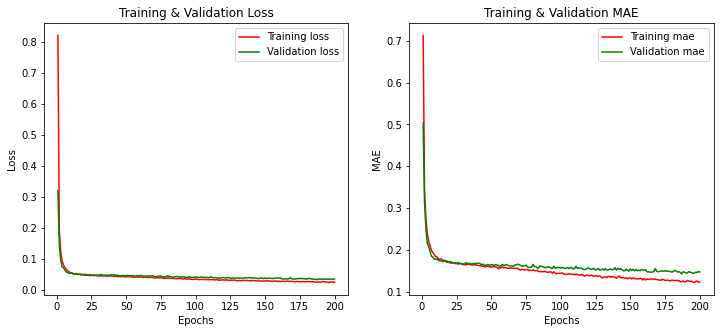

In [ ]:
model_total_ops = total_ops()

history_total_ops = model_total_ops.fit(X_train, y_train, epochs = 200, batch_size = 32, validation_split=0.1, verbose = 0)
dict_total_ops = history_total_ops.history

loss_mae_graph(dict_total_ops)

In [ ]:
total_ops_result = model_total_ops.evaluate(X_test, y_test)
print('rmse: ', round(np.sqrt(total_ops_result[0]), 4), 'mae: ', round(total_ops_result[1], 4))

31/31 [==============================] - 0s 2ms/step - loss: 0.0318 - mae: 0.1356
rmse:  0.1782 mae:  0.1356


In [ ]:
pred_total_ops = model_total_ops.predict(X_predict)

game = np.array((21,21,21,21,21,21,21,21,21,21))

test_total_df_10['game'] = game
test_total_df_10['pred_total_ops'] = pred_total_ops

pred_total_ops = test_total_df_10.loc[:,['NAME', 'PCODE', 'game','pred_total_ops']]
pred_total_ops

,NAME,PCODE,game,pred_total_ops
1,김현수,76290,21,0.836463
36,최정,75847,21,0.642390
83,전준우,78513,21,0.762483
121,이정후,67341,21,0.827748
129,로맥,67872,21,0.818686
155,채은성,79192,21,0.718050
162,박건우,79215,21,0.617697
182,김재환,78224,21,0.898911
215,양의지,76232,21,0.947310
223,강백호,68050,21,0.829712


### **Create data with pre-processing (홈/원정)**

In [ ]:
home_2021 = home_2021[home_2021['ab']>30]
away_2021 = away_2021[away_2021['ab']>30]
home_2020 = home_2020[home_2020['ab']>30]
away_2020 = away_2020[away_2020['ab']>30]
home_2019 = home_2019[home_2019['ab']>30]
away_2019 = away_2019[away_2019['ab']>30]
home_2018 = home_2018[home_2018['ab']>30]
away_2018 = away_2018[away_2018['ab']>30]

In [ ]:
home_data_2021 = cal_feature(home_2021)
away_data_2021 = cal_feature(away_2021)
home_data_2020 = cal_feature(home_2020)
away_data_2020 = cal_feature(away_2020)
home_data_2019 = cal_feature(home_2019)
away_data_2019 = cal_feature(away_2019)
home_data_2018 = cal_feature(home_2018)
away_data_2018 = cal_feature(away_2018)

In [ ]:
#평가할 2021년 데이터셋

test_home_set, test_away_set = HA_final(df_2021, 70)

In [ ]:
test_home_set[test_home_set['NAME'] == '강백호']

,ab,score,hit,2_hit,3_hit,homerun,tb,rbi,sb,cs,bb,hpp,ibb,so,gdp,sh,sf,pitch,WPA,power_barrel,contact_barrel,clutch_barrel,PCODE,NAME
223,105,19,28,10,0,3,47,20,3,1,21,0,3,27,1,0,2,567,1.018,6,8,1,68050,강백호


In [ ]:
# 4년치의 선수 홈/원정 평균을 학습 데이터에 추가

train_home = pd.concat([home_data_2018, home_data_2019, home_data_2020, home_data_2021])
train_away = pd.concat([away_data_2018, away_data_2019, away_data_2020, away_data_2021])

home_player_mean = train_home.groupby('PCODE').mean()[['ops', 'avg', 'obp', 'slg', 'power_barrel', 'contact_barrel', 'clutch_barrel']]
home_player_mean.columns = ['ops_mean', 'avg_mean', 'obp_mean', 'slg_mean', 'power_barrel_mean', 'contact_barrel_mean', 'clutch_barrel_mean']

away_player_mean = train_away.groupby('PCODE').mean()[['ops', 'avg', 'obp', 'slg', 'power_barrel', 'contact_barrel', 'clutch_barrel']]
away_player_mean.columns = ['ops_mean', 'avg_mean', 'obp_mean', 'slg_mean', 'power_barrel_mean', 'contact_barrel_mean', 'clutch_barrel_mean']

train_home_df = train_home.merge(home_player_mean, how='left', on='PCODE')
train_away_df = train_away.merge(away_player_mean, how='left', on='PCODE')

test_home_df = test_home_set.merge(home_player_mean, how='left', on='PCODE')
test_away_df = test_away_set.merge(away_player_mean, how='left', on='PCODE')

In [ ]:
new_home_train_df = train_home_df.loc[:, ['tb', 'rbi', 'sb', 'sh', 'sf', 'ibb', 'WPA', 'avg', 'obp', 'slg', 'ops', 'power_barrel', 'contact_barrel', 'clutch_barrel', 'xh', 'babib', 'pitch/pa', 'cq', 'b/k', 'IsoP', 'IsoD', 'hr%', 'kk%', 'bb%', 'xh/h', 'ueqr','wOBA','obp_label', 'slg_label', 'ops_label' , 'ops_mean', 'avg_mean', 'obp_mean', 'slg_mean', 'power_barrel_mean', 'contact_barrel_mean', 'clutch_barrel_mean']]
new_away_train_df = train_away_df.loc[:, ['tb', 'rbi', 'sb', 'sh', 'sf', 'ibb', 'WPA', 'avg', 'obp', 'slg', 'ops', 'power_barrel', 'contact_barrel', 'clutch_barrel', 'xh', 'babib', 'pitch/pa', 'cq', 'b/k', 'IsoP', 'IsoD', 'hr%', 'kk%', 'bb%', 'xh/h', 'ueqr','wOBA','obp_label', 'slg_label', 'ops_label' , 'ops_mean', 'avg_mean', 'obp_mean', 'slg_mean', 'power_barrel_mean', 'contact_barrel_mean', 'clutch_barrel_mean']]

In [ ]:
new_home_train_df = new_home_train_df.astype('float64')
new_away_train_df = new_away_train_df.astype('float64')

new_home_train_df.shape, new_away_train_df.shape

((3507, 37), (3574, 37))

In [ ]:
test_home_df_10 = test_home_df[(test_home_df['NAME'] == '전준우') | (test_home_df['NAME'] == '박건우') | (test_home_df['NAME'] == '이정후') | (test_home_df['NAME'] == '로맥') | (test_home_df['NAME'] == '강백호') | (test_home_df['NAME'] == '최정') | (test_home_df['NAME'] == '양의지') | (test_home_df['NAME'] == '김현수') | (test_home_df['NAME'] == '김재환') | (test_home_df['NAME'] == '채은성')]
test_away_df_10 = test_away_df[(test_away_df['NAME'] == '전준우') | (test_away_df['NAME'] == '박건우') | (test_away_df['NAME'] == '이정후') | (test_away_df['NAME'] == '로맥') | (test_away_df['NAME'] == '강백호') | (test_away_df['NAME'] == '최정') | (test_away_df['NAME'] == '양의지') | (test_away_df['NAME'] == '김현수') | (test_away_df['NAME'] == '김재환') | (test_away_df['NAME'] == '채은성')]

In [ ]:
test_home_df_10 = cal_feature(test_home_df_10)
test_away_df_10 = cal_feature(test_away_df_10)

### **Train/Test dataset to CSV (홈/원정)**

In [ ]:
#홈/원정 Train data set
new_home_train_df.to_csv('train_home.csv', encoding = 'euc-kr')
new_away_train_df.to_csv('train_away.csv', encoding = 'euc-kr')

In [ ]:
#홈/원정 Test data set
test_home_df_10.to_csv('test_home_df.csv', encoding = 'euc-kr')
test_away_df_10.to_csv('test_away_df.csv', encoding = 'euc-kr')

### **Multi Layer Perceptron (홈/원정)**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow as tf

In [ ]:
#홈 경기 train & test data 분리 및 사용할 feature 선택
mlp_train_home, mlp_test_home = train_test_split(new_home_train_df, test_size=0.2, random_state=20)

X_train_home = mlp_train_home.loc[:, ['rbi', 'sb', 'sh', 'sf', 'ibb', 'WPA', 'avg', 'obp', 'slg', 'ops', 'power_barrel', 'contact_barrel', 'clutch_barrel', 'xh', 'babib', 'pitch/pa', 'cq', 'b/k', 'IsoP', 'IsoD', 'hr%', 'kk%', 'bb%', 'xh/h', 'ueqr','wOBA', 'avg_mean', 'obp_mean', 'slg_mean', 'power_barrel_mean', 'contact_barrel_mean', 'clutch_barrel_mean']]
y_train_home = mlp_train_home.loc[:, ['ops_label']]

X_test_home = mlp_test_home.loc[:, ['rbi', 'sb', 'sh', 'sf', 'ibb', 'WPA', 'avg', 'obp', 'slg', 'ops', 'power_barrel', 'contact_barrel', 'clutch_barrel', 'xh', 'babib', 'pitch/pa', 'cq', 'b/k', 'IsoP', 'IsoD', 'hr%', 'kk%', 'bb%', 'xh/h', 'ueqr','wOBA', 'avg_mean', 'obp_mean', 'slg_mean', 'power_barrel_mean', 'contact_barrel_mean', 'clutch_barrel_mean']]
y_test_home = mlp_test_home.loc[:, ['ops_label']]

In [ ]:
#원정 경기 train & test data 분리 및 사용할 feature 선택
mlp_train_away, mlp_test_away = train_test_split(new_away_train_df, test_size=0.2, random_state=20)

X_train_away = mlp_train_away.loc[:, ['rbi', 'sb', 'sh', 'sf', 'ibb', 'WPA', 'avg', 'obp', 'slg', 'ops', 'power_barrel', 'contact_barrel', 'clutch_barrel', 'xh', 'babib', 'pitch/pa', 'cq', 'b/k', 'IsoP', 'IsoD', 'hr%', 'kk%', 'bb%', 'xh/h', 'ueqr','wOBA', 'avg_mean', 'obp_mean', 'slg_mean', 'power_barrel_mean', 'contact_barrel_mean', 'clutch_barrel_mean']]
y_train_away = mlp_train_away.loc[:, ['ops_label']]

X_test_away = mlp_test_away.loc[:, ['rbi', 'sb', 'sh', 'sf', 'ibb', 'WPA', 'avg', 'obp', 'slg', 'ops', 'power_barrel', 'contact_barrel', 'clutch_barrel', 'xh', 'babib', 'pitch/pa', 'cq', 'b/k', 'IsoP', 'IsoD', 'hr%', 'kk%', 'bb%', 'xh/h', 'ueqr','wOBA', 'avg_mean', 'obp_mean', 'slg_mean', 'power_barrel_mean', 'contact_barrel_mean', 'clutch_barrel_mean']]
y_test_away = mlp_test_away.loc[:, ['ops_label']]

In [ ]:
#홈 경기 :: 학습하기 위한 준비
X_train_home = X_train_home.to_numpy()
y_train_home = y_train_home.to_numpy()
X_test_home = X_test_home.to_numpy()
y_test_home = y_test_home.to_numpy()

number_of_train_home_samples = X_train_home.shape[0]
width_home = X_train_home.shape[1]
X_train_home = X_train_home.reshape(number_of_train_home_samples, width_home)

number_of_test_home_samples = X_test_home.shape[0]
X_test_home = X_test_home.reshape(number_of_test_home_samples, width_home)

y_train_home = y_train_home.reshape(-1)
y_test_home = y_test_home.reshape(-1)

#원정 경기 :: 학습하기 위한 준비
X_train_away = X_train_away.to_numpy()
y_train_away = y_train_away.to_numpy()
X_test_away = X_test_away.to_numpy()
y_test_away = y_test_away.to_numpy()

number_of_train_away_samples = X_train_away.shape[0]
width_away = X_train_away.shape[1]
X_train_away = X_train_away.reshape(number_of_train_away_samples, width_away)

number_of_test_away_samples = X_test_away.shape[0]
X_test_away = X_test_away.reshape(number_of_test_away_samples, width_away)

y_train_away = y_train_away.reshape(-1)
y_test_away = y_test_away.reshape(-1)

In [ ]:
#Standard Scaling 후, 학습/테스트 데이터 형태 확인
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_home = scaler.fit_transform(X_train_home)
X_test_home = scaler.fit_transform(X_test_home)

X_train_away = scaler.fit_transform(X_train_away)
X_test_away = scaler.fit_transform(X_test_away)

print("home data shape: ", X_train_home.shape, X_test_home.shape, y_train_home.shape, y_test_home.shape)
print("away data shape: ", X_train_away.shape, X_test_away.shape, y_train_away.shape, y_test_away.shape)

home data shape:  (2805, 32) (702, 32) (2805,) (702,)
away data shape:  (2859, 32) (715, 32) (2859,) (715,)


In [ ]:
#실제 예측에 사용될 10명의 선수 데이터셋
X_predict_home = test_home_df_10.loc[:, ['rbi', 'sb', 'sh', 'sf', 'ibb', 'WPA', 'avg', 'obp', 'slg', 'ops', 'power_barrel', 'contact_barrel', 'clutch_barrel', 'xh', 'babib', 'pitch/pa', 'cq', 'b/k', 'IsoP', 'IsoD', 'hr%', 'kk%', 'bb%', 'xh/h', 'ueqr','wOBA', 'avg_mean', 'obp_mean', 'slg_mean', 'power_barrel_mean', 'contact_barrel_mean', 'clutch_barrel_mean']]
X_predict_home = X_predict_home.to_numpy()
X_predict_home = X_predict_home.reshape(X_predict_home.shape[0], X_predict_home.shape[1])
X_predict_home = scaler.fit_transform(X_predict_home)

X_predict_away = test_away_df_10.loc[:, ['rbi', 'sb', 'sh', 'sf', 'ibb', 'WPA', 'avg', 'obp', 'slg', 'ops', 'power_barrel', 'contact_barrel', 'clutch_barrel', 'xh', 'babib', 'pitch/pa', 'cq', 'b/k', 'IsoP', 'IsoD', 'hr%', 'kk%', 'bb%', 'xh/h', 'ueqr','wOBA', 'avg_mean', 'obp_mean', 'slg_mean', 'power_barrel_mean', 'contact_barrel_mean', 'clutch_barrel_mean']]
X_predict_away = X_predict_away.to_numpy()
X_predict_away = X_predict_away.reshape(X_predict_away.shape[0], X_predict_away.shape[1])
X_predict_away = scaler.fit_transform(X_predict_away)

X_predict_home.shape, X_predict_away.shape

((10, 32), (10, 32))

In [ ]:
from keras.layers import BatchNormalization

def home_ops():
    model = Sequential()

    model.add(Dense(64, input_dim= width_home, kernel_initializer = 'HeNormal'))
    model.add(BatchNormalization()) 
    model.add(Activation('relu'))
    model.add(Dropout(0.1)) 
    model.add(Dense(32, kernel_initializer = 'HeNormal'))
    model.add(BatchNormalization()) 
    model.add(Activation('relu'))
    model.add(Dropout(0.1)) 
    model.add(Dense(1))

    adam = tf.keras.optimizers.Adam(learning_rate = 0.001)
    model.compile(loss = 'mean_squared_error', optimizer = adam, metrics=['mae'])

    return model

In [ ]:
from keras.layers import BatchNormalization

def away_ops():
    model = Sequential()

    model.add(Dense(64, input_dim= width_home, kernel_initializer = 'HeNormal'))
    model.add(BatchNormalization()) 
    model.add(Activation('relu'))
    model.add(Dropout(0.1)) 
    model.add(Dense(32, kernel_initializer = 'HeNormal'))
    model.add(BatchNormalization()) 
    model.add(Activation('relu'))
    model.add(Dropout(0.1)) 
    model.add(Dense(1))

    adam = tf.keras.optimizers.Adam(learning_rate = 0.001)
    model.compile(loss = 'mean_squared_error', optimizer = adam, metrics=['mae'])

    return model

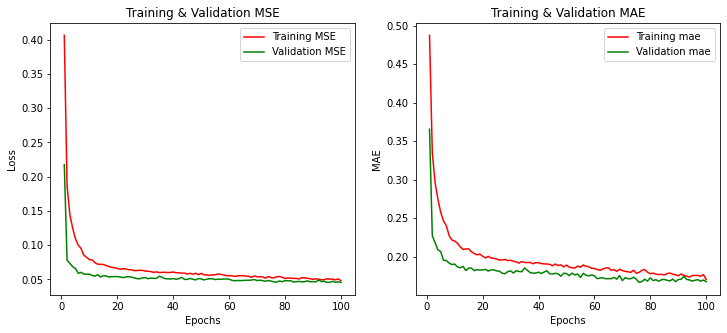

In [ ]:
model_home_ops = home_ops()

history_home_ops = model_home_ops.fit(X_train_home, y_train_home, epochs = 100, batch_size = 16, validation_split=0.1, verbose = 0)
dict_home_ops = history_home_ops.history

loss_mae_graph(dict_home_ops)

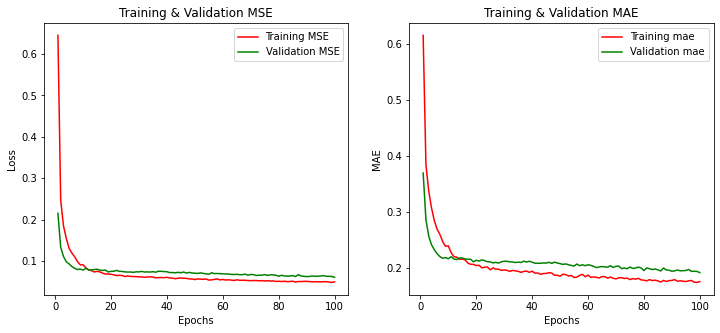

In [ ]:
model_away_ops = away_ops()

history_away_ops = model_away_ops.fit(X_train_away, y_train_away, epochs = 100, batch_size = 16, validation_split=0.1, verbose = 0)
dict_away_ops = history_away_ops.history

loss_mae_graph(dict_away_ops)

In [ ]:
home_ops_result = model_home_ops.evaluate(X_test_home, y_test_home)
away_ops_result = model_away_ops.evaluate(X_test_away, y_test_away)

print('home data rmse: ', round(np.sqrt(home_ops_result[0]), 4), 'mae: ', round(home_ops_result[1], 4))
print('away data rmse: ', round(np.sqrt(away_ops_result[0]), 4), 'mae: ', round(away_ops_result[1], 4))

23/23 [==============================] - 0s 1ms/step - loss: 0.0569 - mae: 0.1868
home data rmse:  0.238 mae:  0.1783
away data rmse:  0.2386 mae:  0.1868


In [ ]:
pred_home_ops = model_home_ops.predict(X_predict_home)
pred_away_ops = model_away_ops.predict(X_predict_away)

home_game = np.array((10, 9, 8, 12, 9, 10, 11, 11, 9, 12))
away_game = np.array((11, 12, 13, 9, 12, 11, 10, 10, 12, 9))

test_home_df_10['home_game'] = home_game
test_home_df_10['away_game'] = away_game

test_home_df_10['pred_home_ops'] = pred_home_ops
test_home_df_10['pred_away_ops'] = pred_away_ops

khs_ops = (test_home_df_10['pred_home_ops'].iloc[0] * 10 / 21) + (test_home_df_10['pred_away_ops'].iloc[0] * 11 / 21)
cj_ops = (test_home_df_10['pred_home_ops'].iloc[1] * 9 / 21) + (test_home_df_10['pred_away_ops'].iloc[1] * 12 / 21)
jjw_ops = (test_home_df_10['pred_home_ops'].iloc[2] * 8 / 21) + (test_home_df_10['pred_away_ops'].iloc[2] * 13 / 21)
ljh_ops = (test_home_df_10['pred_home_ops'].iloc[3] * 12 / 21) + (test_home_df_10['pred_away_ops'].iloc[3] * 9 / 21)
lm_ops = (test_home_df_10['pred_home_ops'].iloc[4] * 9 / 21) + (test_home_df_10['pred_away_ops'].iloc[4] * 12 / 21)
ces_ops = (test_home_df_10['pred_home_ops'].iloc[5] * 10 / 21) + (test_home_df_10['pred_away_ops'].iloc[5] * 11 / 21)
pgw_ops = (test_home_df_10['pred_home_ops'].iloc[6] * 11 / 21) + (test_home_df_10['pred_away_ops'].iloc[6] * 10 / 21)
kjh_ops = (test_home_df_10['pred_home_ops'].iloc[7] * 11 / 21) + (test_home_df_10['pred_away_ops'].iloc[7] * 10 / 21)
yej_ops = (test_home_df_10['pred_home_ops'].iloc[8] * 9 / 21) + (test_home_df_10['pred_away_ops'].iloc[8] * 12 / 21)
kbh_ops = (test_home_df_10['pred_home_ops'].iloc[9] * 12 / 21) + (test_home_df_10['pred_away_ops'].iloc[9] * 9 / 21)

ops_weighted = np.array((khs_ops, cj_ops, jjw_ops, ljh_ops, lm_ops, ces_ops, pgw_ops, kjh_ops, yej_ops, kbh_ops))

test_home_df_10['ops_weighted'] = ops_weighted

pred_home_away_ops = test_home_df_10.loc[:,['NAME', 'PCODE', 'home_game', 'away_game', 'pred_home_ops', 'pred_away_ops', 'ops_weighted']]
pred_home_away_ops

,NAME,PCODE,home_game,away_game,pred_home_ops,pred_away_ops,ops_weighted
1,김현수,76290,10,11,0.807522,0.871301,0.840930
36,최정,75847,9,12,0.951122,0.743979,0.832754
83,전준우,78513,8,13,0.770593,0.623967,0.679825
121,이정후,67341,12,9,0.703004,0.813418,0.750324
129,로맥,67872,9,12,0.739145,0.809750,0.779491
155,채은성,79192,10,11,0.708021,0.694772,0.701081
162,박건우,79215,11,10,0.412905,0.706138,0.552540
182,김재환,78224,11,10,0.736278,0.955894,0.840857
215,양의지,76232,9,12,0.963665,0.934944,0.947253
223,강백호,68050,12,9,0.935121,0.747695,0.854795


### **Multi Layer Perceptron (홈/원정 > 출루율/장타율)**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow as tf

In [ ]:
#홈 경기 출루율/ 장타율 train & test data 분리 및 사용할 feature 선택
mlp_train_home, mlp_test_home = train_test_split(new_home_train_df, test_size=0.2, random_state=20)

#홈 출루율 train data
X_train_home_obp = mlp_train_home.loc[:, ['rbi', 'sb', 'sh', 'sf', 'ibb', 'WPA', 'avg', 'obp', 'slg', 'ops', 'power_barrel', 'contact_barrel', 'clutch_barrel', 'xh', 'babib', 'pitch/pa', 'cq', 'b/k', 'IsoP', 'IsoD', 'hr%', 'kk%', 'bb%', 'xh/h', 'ueqr','wOBA','avg_mean', 'obp_mean', 'power_barrel_mean', 'contact_barrel_mean', 'clutch_barrel_mean']]
y_train_home_obp = mlp_train_home.loc[:, ['obp_label']]

X_test_home_obp = mlp_test_home.loc[:, ['rbi', 'sb', 'sh', 'sf', 'ibb', 'WPA', 'avg', 'obp', 'slg', 'ops', 'power_barrel', 'contact_barrel', 'clutch_barrel', 'xh', 'babib', 'pitch/pa', 'cq', 'b/k', 'IsoP', 'IsoD', 'hr%', 'kk%', 'bb%', 'xh/h', 'ueqr','wOBA', 'avg_mean', 'obp_mean', 'power_barrel_mean', 'contact_barrel_mean', 'clutch_barrel_mean']]
y_test_home_obp = mlp_test_home.loc[:, ['obp_label']]

#홈 장타율 train data
X_train_home_slg = mlp_train_home.loc[:, ['rbi', 'sb', 'sh', 'sf', 'ibb', 'WPA', 'avg', 'obp', 'slg', 'ops', 'power_barrel', 'contact_barrel', 'clutch_barrel', 'xh', 'babib', 'pitch/pa', 'cq', 'b/k', 'IsoP', 'IsoD', 'hr%', 'kk%', 'bb%', 'xh/h', 'ueqr','wOBA','avg_mean', 'slg_mean', 'power_barrel_mean', 'contact_barrel_mean', 'clutch_barrel_mean']]
y_train_home_slg = mlp_train_home.loc[:, ['slg_label']]

X_test_home_slg = mlp_test_home.loc[:, ['rbi', 'sb', 'sh', 'sf', 'ibb', 'WPA', 'avg', 'obp', 'slg', 'ops', 'power_barrel', 'contact_barrel', 'clutch_barrel', 'xh', 'babib', 'pitch/pa', 'cq', 'b/k', 'IsoP', 'IsoD', 'hr%', 'kk%', 'bb%', 'xh/h', 'ueqr','wOBA', 'avg_mean', 'slg_mean', 'power_barrel_mean', 'contact_barrel_mean', 'clutch_barrel_mean']]
y_test_home_slg = mlp_test_home.loc[:, ['slg_label']]

In [ ]:
#원정 경기 출루율/ 장타율 train & test data 분리 및 사용할 feature 선택
mlp_train_away, mlp_test_away = train_test_split(new_away_train_df, test_size=0.2, random_state=20)

#원정 출루율 train data
X_train_away_obp = mlp_train_away.loc[:, ['rbi', 'sb', 'sh', 'sf', 'ibb', 'WPA', 'avg', 'obp', 'slg', 'ops', 'power_barrel', 'contact_barrel', 'clutch_barrel', 'xh', 'babib', 'pitch/pa', 'cq', 'b/k', 'IsoP', 'IsoD', 'hr%', 'kk%', 'bb%', 'xh/h', 'ueqr','wOBA','avg_mean', 'obp_mean', 'power_barrel_mean', 'contact_barrel_mean', 'clutch_barrel_mean']]
y_train_away_obp = mlp_train_away.loc[:, ['obp_label']]

X_test_away_obp = mlp_test_away.loc[:, ['rbi', 'sb', 'sh', 'sf', 'ibb', 'WPA', 'avg', 'obp', 'slg', 'ops', 'power_barrel', 'contact_barrel', 'clutch_barrel', 'xh', 'babib', 'pitch/pa', 'cq', 'b/k', 'IsoP', 'IsoD', 'hr%', 'kk%', 'bb%', 'xh/h', 'ueqr','wOBA', 'avg_mean', 'obp_mean', 'power_barrel_mean', 'contact_barrel_mean', 'clutch_barrel_mean']]
y_test_away_obp = mlp_test_away.loc[:, ['obp_label']]

#원정 장타율 train data
X_train_away_slg = mlp_train_away.loc[:, ['rbi', 'sb', 'sh', 'sf', 'ibb', 'WPA', 'avg', 'obp', 'slg', 'ops', 'power_barrel', 'contact_barrel', 'clutch_barrel', 'xh', 'babib', 'pitch/pa', 'cq', 'b/k', 'IsoP', 'IsoD', 'hr%', 'kk%', 'bb%', 'xh/h', 'ueqr','wOBA','avg_mean', 'slg_mean', 'power_barrel_mean', 'contact_barrel_mean', 'clutch_barrel_mean']]
y_train_away_slg = mlp_train_away.loc[:, ['slg_label']]

X_test_away_slg = mlp_test_away.loc[:, ['rbi', 'sb', 'sh', 'sf', 'ibb', 'WPA', 'avg', 'obp', 'slg', 'ops', 'power_barrel', 'contact_barrel', 'clutch_barrel', 'xh', 'babib', 'pitch/pa', 'cq', 'b/k', 'IsoP', 'IsoD', 'hr%', 'kk%', 'bb%', 'xh/h', 'ueqr','wOBA', 'avg_mean', 'slg_mean', 'power_barrel_mean', 'contact_barrel_mean', 'clutch_barrel_mean']]
y_test_away_slg = mlp_test_away.loc[:, ['slg_label']]

In [ ]:
#홈 출루율 :: 학습하기 위한 준비
X_train_home_obp = X_train_home_obp.to_numpy()
y_train_home_obp = y_train_home_obp.to_numpy()
X_test_home_obp = X_test_home_obp.to_numpy()
y_test_home_obp = y_test_home_obp.to_numpy()

number_of_train_home_obp_samples = X_train_home_obp.shape[0]
width_home_obp = X_train_home_obp.shape[1]
X_train_home_obp = X_train_home_obp.reshape(number_of_train_home_obp_samples, width_home_obp)

number_of_test_home_obp_samples = X_test_home_obp.shape[0]
X_test_home_obp = X_test_home_obp.reshape(number_of_test_home_obp_samples, width_home_obp)

y_train_home_obp = y_train_home_obp.reshape(-1)
y_test_home_obp = y_test_home_obp.reshape(-1)

#홈 장타율 :: 학습하기 위한 준비
X_train_home_slg = X_train_home_slg.to_numpy()
y_train_home_slg = y_train_home_slg.to_numpy()
X_test_home_slg = X_test_home_slg.to_numpy()
y_test_home_slg = y_test_home_slg.to_numpy()

number_of_train_home_slg_samples = X_train_home_slg.shape[0]
width_home_slg = X_train_home_slg.shape[1]
X_train_home_slg = X_train_home_slg.reshape(number_of_train_home_slg_samples, width_home_slg)

number_of_test_home_slg_samples = X_test_home_slg.shape[0]
X_test_home_slg = X_test_home_slg.reshape(number_of_test_home_slg_samples, width_home_slg)

y_train_home_slg = y_train_home_slg.reshape(-1)
y_test_home_slg = y_test_home_slg.reshape(-1)

#원정 출루율 :: 학습하기 위한 준비
X_train_away_obp = X_train_away_obp.to_numpy()
y_train_away_obp = y_train_away_obp.to_numpy()
X_test_away_obp = X_test_away_obp.to_numpy()
y_test_away_obp = y_test_away_obp.to_numpy()

number_of_train_away_obp_samples = X_train_away_obp.shape[0]
width_away_obp = X_train_away_obp.shape[1]
X_train_away_obp = X_train_away_obp.reshape(number_of_train_away_obp_samples, width_away_obp)

number_of_test_away_obp_samples = X_test_away_obp.shape[0]
X_test_away_obp = X_test_away_obp.reshape(number_of_test_away_obp_samples, width_away_obp)

y_train_away_obp = y_train_away_obp.reshape(-1)
y_test_away_obp = y_test_away_obp.reshape(-1)

#원정 장타율 :: 학습하기 위한 준비
X_train_away_slg = X_train_away_slg.to_numpy()
y_train_away_slg = y_train_away_slg.to_numpy()
X_test_away_slg = X_test_away_slg.to_numpy()
y_test_away_slg = y_test_away_slg.to_numpy()

number_of_train_away_slg_samples = X_train_away_slg.shape[0]
width_away_slg = X_train_away_slg.shape[1]
X_train_away_slg = X_train_away_slg.reshape(number_of_train_away_slg_samples, width_away_slg)

number_of_test_away_slg_samples = X_test_away_slg.shape[0]
X_test_away_slg = X_test_away_slg.reshape(number_of_test_away_slg_samples, width_away_slg)

y_train_away_slg = y_train_away_slg.reshape(-1)
y_test_away_slg = y_test_away_slg.reshape(-1)

In [ ]:
#Standard Scaling 후, 학습/테스트 데이터 형태 확인
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_home_obp = scaler.fit_transform(X_train_home_obp)
X_test_home_obp = scaler.fit_transform(X_test_home_obp)

X_train_home_slg = scaler.fit_transform(X_train_home_slg)
X_test_home_slg = scaler.fit_transform(X_test_home_slg)

X_train_away_obp = scaler.fit_transform(X_train_away_obp)
X_test_away_obp = scaler.fit_transform(X_test_away_obp)

X_train_away_slg = scaler.fit_transform(X_train_away_slg)
X_test_away_slg = scaler.fit_transform(X_test_away_slg)

print("home obp data shape: ", X_train_home_obp.shape, X_test_home_obp.shape, y_train_home_obp.shape, y_test_home_obp.shape)
print("away obp data shape: ", X_train_away_obp.shape, X_test_away_obp.shape, y_train_away_obp.shape, y_test_away_obp.shape)

print("home slg data shape: ", X_train_home_slg.shape, X_test_home_slg.shape, y_train_home_slg.shape, y_test_home_slg.shape)
print("away slg data shape: ", X_train_away_slg.shape, X_test_away_slg.shape, y_train_away_slg.shape, y_test_away_slg.shape)

home obp data shape:  (2805, 31) (702, 31) (2805,) (702,)
away obp data shape:  (2859, 31) (715, 31) (2859,) (715,)
home slg data shape:  (2805, 31) (702, 31) (2805,) (702,)
away slg data shape:  (2859, 31) (715, 31) (2859,) (715,)


In [ ]:
#실제 예측에 사용될 10명의 선수 데이터셋
X_predict_home_obp = test_home_df_10.loc[:, ['rbi', 'sb', 'sh', 'sf', 'ibb', 'WPA', 'avg', 'obp', 'slg', 'ops', 'power_barrel', 'contact_barrel', 'clutch_barrel', 'xh', 'babib', 'pitch/pa', 'cq', 'b/k', 'IsoP', 'IsoD', 'hr%', 'kk%', 'bb%', 'xh/h', 'ueqr','wOBA', 'avg_mean', 'obp_mean', 'power_barrel_mean', 'contact_barrel_mean', 'clutch_barrel_mean']]
X_predict_home_obp = X_predict_home_obp.to_numpy()
X_predict_home_obp = X_predict_home_obp.reshape(X_predict_home_obp.shape[0], X_predict_home_obp.shape[1])
X_predict_home_obp = scaler.fit_transform(X_predict_home_obp)

X_predict_away_obp = test_away_df_10.loc[:, ['rbi', 'sb', 'sh', 'sf', 'ibb', 'WPA', 'avg', 'obp', 'slg', 'ops', 'power_barrel', 'contact_barrel', 'clutch_barrel', 'xh', 'babib', 'pitch/pa', 'cq', 'b/k', 'IsoP', 'IsoD', 'hr%', 'kk%', 'bb%', 'xh/h', 'ueqr','wOBA', 'avg_mean', 'obp_mean', 'power_barrel_mean', 'contact_barrel_mean', 'clutch_barrel_mean']]
X_predict_away_obp = X_predict_away_obp.to_numpy()
X_predict_away_obp = X_predict_away_obp.reshape(X_predict_away_obp.shape[0], X_predict_away_obp.shape[1])
X_predict_away_obp = scaler.fit_transform(X_predict_away_obp)

X_predict_home_slg = test_home_df_10.loc[:, ['rbi', 'sb', 'sh', 'sf', 'ibb', 'WPA', 'avg', 'obp', 'slg', 'ops', 'power_barrel', 'contact_barrel', 'clutch_barrel', 'xh', 'babib', 'pitch/pa', 'cq', 'b/k', 'IsoP', 'IsoD', 'hr%', 'kk%', 'bb%', 'xh/h', 'ueqr','wOBA', 'avg_mean', 'slg_mean', 'power_barrel_mean', 'contact_barrel_mean', 'clutch_barrel_mean']]
X_predict_home_slg = X_predict_home_slg.to_numpy()
X_predict_home_slg = X_predict_home_slg.reshape(X_predict_home_slg.shape[0], X_predict_home_slg.shape[1])
X_predict_home_slg = scaler.fit_transform(X_predict_home_slg)

X_predict_away_slg = test_away_df_10.loc[:, ['rbi', 'sb', 'sh', 'sf', 'ibb', 'WPA', 'avg', 'obp', 'slg', 'ops', 'power_barrel', 'contact_barrel', 'clutch_barrel', 'xh', 'babib', 'pitch/pa', 'cq', 'b/k', 'IsoP', 'IsoD', 'hr%', 'kk%', 'bb%', 'xh/h', 'ueqr','wOBA', 'avg_mean', 'slg_mean', 'power_barrel_mean', 'contact_barrel_mean', 'clutch_barrel_mean']]
X_predict_away_slg = X_predict_away_slg.to_numpy()
X_predict_away_slg = X_predict_away_slg.reshape(X_predict_away_slg.shape[0], X_predict_away_slg.shape[1])
X_predict_away_slg = scaler.fit_transform(X_predict_away_slg)

X_predict_home_obp.shape, X_predict_away_obp.shape, X_predict_home_slg.shape, X_predict_away_slg.shape

((10, 31), (10, 31), (10, 31), (10, 31))

In [ ]:
from keras.layers import BatchNormalization

def home_away_obp_slg():
    model = Sequential()

    model.add(Dense(64, input_dim= width_home_slg, kernel_initializer = 'HeNormal'))
    model.add(BatchNormalization()) 
    model.add(Activation('relu'))
    model.add(Dropout(0.2)) 
    model.add(Dense(32, kernel_initializer = 'HeNormal'))
    model.add(BatchNormalization()) 
    model.add(Activation('relu'))
    model.add(Dropout(0.2)) 
    model.add(Dense(1))

    adam = tf.keras.optimizers.Adam(learning_rate = 0.001)
    model.compile(loss = 'mean_squared_error', optimizer = adam, metrics=['mae'])

    return model

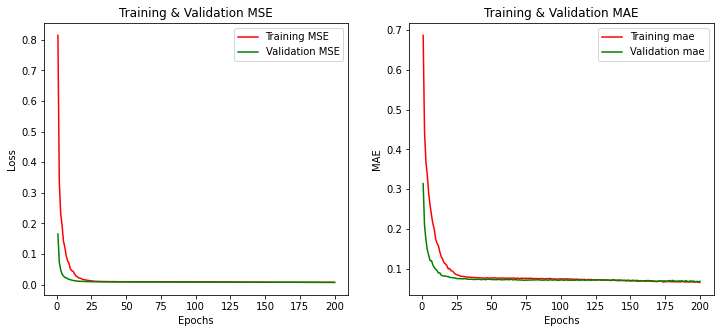

In [ ]:
model_home_obp = home_away_obp_slg()

history_home_obp = model_home_obp.fit(X_train_home_obp, y_train_home_obp, epochs = 200, batch_size = 32, validation_split=0.1, verbose = 0)
dict_home_obp = history_home_obp.history

loss_mae_graph(dict_home_obp)

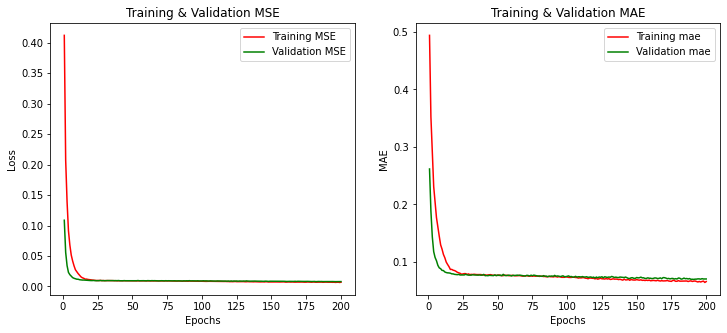

In [ ]:
model_away_obp = home_away_obp_slg()

history_away_obp = model_away_obp.fit(X_train_away_obp, y_train_away_obp, epochs = 200, batch_size = 32, validation_split=0.1, verbose = 0)
dict_away_obp = history_away_obp.history

loss_mae_graph(dict_away_obp)

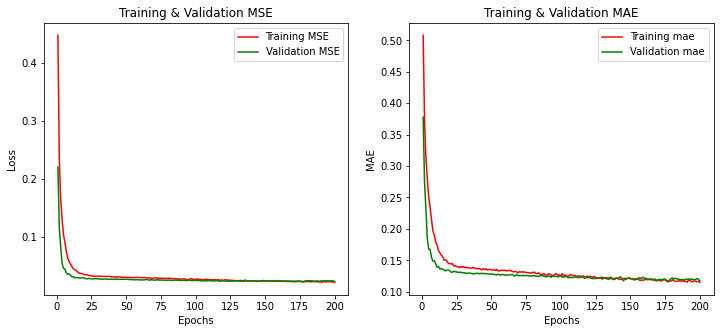

In [ ]:
model_home_slg = home_away_obp_slg()

history_home_slg = model_home_slg.fit(X_train_home_slg, y_train_home_slg, epochs = 200, batch_size = 32, validation_split=0.1, verbose = 0)
dict_home_slg = history_home_slg.history

loss_mae_graph(dict_home_slg)

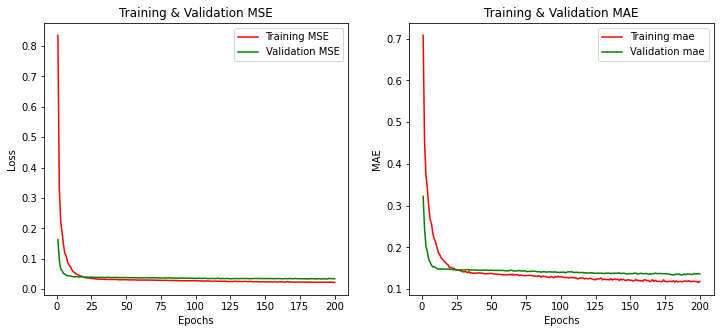

In [ ]:
model_away_slg = home_away_obp_slg()

history_away_slg = model_away_slg.fit(X_train_away_slg, y_train_away_slg, epochs = 200, batch_size = 32, validation_split=0.1, verbose = 0)
dict_away_slg = history_away_slg.history

loss_mae_graph(dict_away_slg)

In [ ]:
home_obp_result = model_home_obp.evaluate(X_test_home_obp, y_test_home_obp)
away_obp_result = model_away_obp.evaluate(X_test_away_obp, y_test_away_obp)

home_slg_result = model_home_slg.evaluate(X_test_home_slg, y_test_home_slg)
away_slg_result = model_away_slg.evaluate(X_test_away_slg, y_test_away_slg)

print('home obp data rmse: ', round(np.sqrt(home_obp_result[0]), 4), 'mae: ', round(home_obp_result[1], 4))
print('away obp data rmse: ', round(np.sqrt(away_obp_result[0]), 4), 'mae: ', round(away_obp_result[1], 4))
print('home slg data rmse: ', round(np.sqrt(home_slg_result[0]), 4), 'mae: ', round(home_slg_result[1], 4))
print('away slg data rmse: ', round(np.sqrt(away_slg_result[0]), 4), 'mae: ', round(away_slg_result[1], 4))

23/23 [==============================] - 0s 1ms/step - loss: 0.0253 - mae: 0.1249
home obp data rmse:  0.0893 mae:  0.0681
away obp data rmse:  0.0891 mae:  0.0685
home slg data rmse:  0.1628 mae:  0.1216
away slg data rmse:  0.159 mae:  0.1249


In [ ]:
#홈/원정 출루율 예측 
pred_home_obp = model_home_obp.predict(X_predict_home_obp)
pred_away_obp = model_away_obp.predict(X_predict_away_obp)

home_game = np.array((10, 9, 8, 12, 9, 10, 11, 11, 9, 12))
away_game = np.array((11, 12, 13, 9, 12, 11, 10, 10, 12, 9))

test_away_df_10['home_game'] = home_game
test_away_df_10['away_game'] = away_game

test_away_df_10['pred_home_obp'] = pred_home_obp
test_away_df_10['pred_away_obp'] = pred_away_obp

khs_obp = (test_away_df_10['pred_home_obp'].iloc[0] * 10 / 21) + (test_away_df_10['pred_away_obp'].iloc[0] * 11 / 21)
cj_obp = (test_away_df_10['pred_home_obp'].iloc[1] * 9 / 21) + (test_away_df_10['pred_away_obp'].iloc[1] * 12 / 21)
jjw_obp = (test_away_df_10['pred_home_obp'].iloc[2] * 8 / 21) + (test_away_df_10['pred_away_obp'].iloc[2] * 13 / 21)
ljh_obp = (test_away_df_10['pred_home_obp'].iloc[3] * 12 / 21) + (test_away_df_10['pred_away_obp'].iloc[3] * 9 / 21)
lm_obp = (test_away_df_10['pred_home_obp'].iloc[4] * 9 / 21) + (test_away_df_10['pred_away_obp'].iloc[4] * 12 / 21)
ces_obp = (test_away_df_10['pred_home_obp'].iloc[5] * 10 / 21) + (test_away_df_10['pred_away_obp'].iloc[5] * 11 / 21)
pgw_obp = (test_away_df_10['pred_home_obp'].iloc[6] * 11 / 21) + (test_away_df_10['pred_away_obp'].iloc[6] * 10 / 21)
kjh_obp = (test_away_df_10['pred_home_obp'].iloc[7] * 11 / 21) + (test_away_df_10['pred_away_obp'].iloc[7] * 10 / 21)
yej_obp = (test_away_df_10['pred_home_obp'].iloc[8] * 9 / 21) + (test_away_df_10['pred_away_obp'].iloc[8] * 12 / 21)
kbh_obp = (test_away_df_10['pred_home_obp'].iloc[9] * 12 / 21) + (test_away_df_10['pred_away_obp'].iloc[9] * 9 / 21)

#홈/원정 장타율 예측 
pred_home_slg = model_home_slg.predict(X_predict_home_slg)
pred_away_slg = model_away_slg.predict(X_predict_away_slg)

test_away_df_10['pred_home_slg'] = pred_home_slg
test_away_df_10['pred_away_slg'] = pred_away_slg

khs_slg = (test_away_df_10['pred_home_slg'].iloc[0] * 10 / 21) + (test_away_df_10['pred_away_slg'].iloc[0] * 11 / 21)
cj_slg = (test_away_df_10['pred_home_slg'].iloc[1] * 9 / 21) + (test_away_df_10['pred_away_slg'].iloc[1] * 12 / 21)
jjw_slg = (test_away_df_10['pred_home_slg'].iloc[2] * 8 / 21) + (test_away_df_10['pred_away_slg'].iloc[2] * 13 / 21)
ljh_slg = (test_away_df_10['pred_home_slg'].iloc[3] * 12 / 21) + (test_away_df_10['pred_away_slg'].iloc[3] * 9 / 21)
lm_slg = (test_away_df_10['pred_home_slg'].iloc[4] * 9 / 21) + (test_away_df_10['pred_away_slg'].iloc[4] * 12 / 21)
ces_slg = (test_away_df_10['pred_home_slg'].iloc[5] * 10 / 21) + (test_away_df_10['pred_away_slg'].iloc[5] * 11 / 21)
pgw_slg = (test_away_df_10['pred_home_slg'].iloc[6] * 11 / 21) + (test_away_df_10['pred_away_slg'].iloc[6] * 10 / 21)
kjh_slg = (test_away_df_10['pred_home_slg'].iloc[7] * 11 / 21) + (test_away_df_10['pred_away_slg'].iloc[7] * 10 / 21)
yej_slg = (test_away_df_10['pred_home_slg'].iloc[8] * 9 / 21) + (test_away_df_10['pred_away_slg'].iloc[8] * 12 / 21)
kbh_slg = (test_away_df_10['pred_home_slg'].iloc[9] * 12 / 21) + (test_away_df_10['pred_away_slg'].iloc[9] * 9 / 21)

obp_weighted = np.array((khs_obp, cj_obp, jjw_obp, ljh_obp, lm_obp, ces_obp, pgw_obp, kjh_obp, yej_obp, kbh_obp))
slg_weighted = np.array((khs_slg, cj_slg, jjw_slg, ljh_slg, lm_slg, ces_slg, pgw_slg, kjh_slg, yej_slg, kbh_slg))

test_away_df_10['obp_weighted'] = obp_weighted
test_away_df_10['slg_weighted'] = slg_weighted
test_away_df_10['ops_weighted'] = obp_weighted + slg_weighted

pred_home_away_obp_slg = test_away_df_10.loc[:,['NAME', 'PCODE', 'home_game', 'away_game', 'obp_weighted', 'slg_weighted', 'ops_weighted']]
pred_home_away_obp_slg

,NAME,PCODE,home_game,away_game,obp_weighted,slg_weighted,ops_weighted
1,김현수,76290,10,11,0.352252,0.403693,0.755945
36,최정,75847,9,12,0.361294,0.442754,0.804047
83,전준우,78513,8,13,0.294684,0.306274,0.600958
121,이정후,67341,12,9,0.382244,0.451879,0.834122
129,로맥,67872,9,12,0.383912,0.508419,0.892331
155,채은성,79192,10,11,0.256794,0.373178,0.629972
162,박건우,79215,11,10,0.291887,0.310930,0.602818
182,김재환,78224,11,10,0.357389,0.514919,0.872308
215,양의지,76232,9,12,0.437568,0.527920,0.965489
223,강백호,68050,12,9,0.406406,0.388707,0.795112


In [ ]:
pred_home_away_obp_slg['ops_weighted_once'] = pred_home_away_ops['ops_weighted']
pred_home_away_obp_slg

,NAME,PCODE,home_game,away_game,obp_weighted,slg_weighted,ops_weighted,ops_weighted_once
1,김현수,76290,10,11,0.352252,0.403693,0.755945,0.840930
36,최정,75847,9,12,0.361294,0.442754,0.804047,0.832754
83,전준우,78513,8,13,0.294684,0.306274,0.600958,0.679825
121,이정후,67341,12,9,0.382244,0.451879,0.834122,0.750324
129,로맥,67872,9,12,0.383912,0.508419,0.892331,0.779491
155,채은성,79192,10,11,0.256794,0.373178,0.629972,0.701081
162,박건우,79215,11,10,0.291887,0.310930,0.602818,0.552540
182,김재환,78224,11,10,0.357389,0.514919,0.872308,0.840857
215,양의지,76232,9,12,0.437568,0.527920,0.965489,0.947253
223,강백호,68050,12,9,0.406406,0.388707,0.795112,0.854795


### **Filter Method**

In [ ]:
home_frames = [home_data_2018, home_data_2019, home_data_2020, home_data_2021]
new_home_data = pd.concat(home_frames)

In [ ]:
away_frames = [away_data_2018, away_data_2019, away_data_2020, away_data_2021]
new_away_data = pd.concat(away_frames)

In [ ]:
new_home_data.shape

(3573, 52)

In [ ]:
new_df = new_home_data.loc[:, ['tb', 'rbi', 'sb', 'sh', 'sf', 'WPA', 'avg', 'obp', 'slg', 'power_barrel', 'contact_barrel', 'clutch_barrel', 'xh', 'babib', 'pitch/pa', 'cq', 'b/k', 'IsoP', 'IsoD', 'psn', 'hr%', 'kk%', 'bb%', 'xh/h', 'hr/xh', 'ueqr','wOBA', 'ops', 'obp_label']]

In [ ]:
new_df = new_df.astype('float64')

In [ ]:
new_df.shape

(3573, 29)

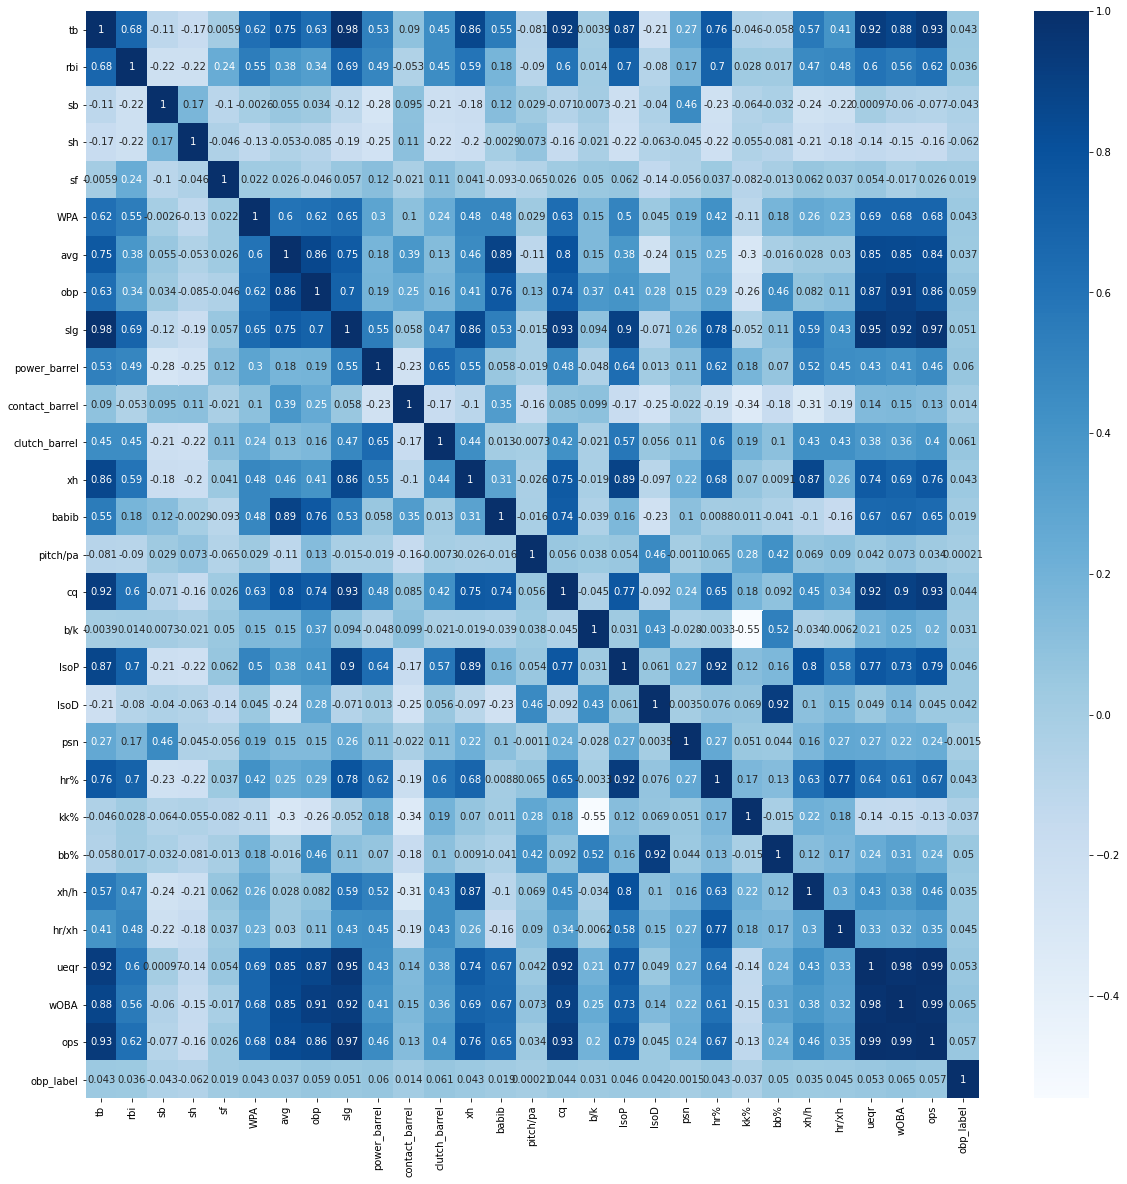

In [ ]:
#Using Pearson Correlation
plt.figure(figsize=(20,20))
cor = new_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.show()

In [ ]:
#Correlation with output variable
cor_target = abs(cor['obp_label'])

#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.4]
relevant_features

obp_label    1.0
Name: obp_label, dtype: float64

In [ ]:
#Correlation with output variable
cor_target = abs(cor['obp_label'])

#Selecting highly correlated features
relevant_features = cor_target.sort_values(ascending = False)[:15]
relevant_features

obp_label        1.000000
wOBA             0.065029
sh               0.061724
clutch_barrel    0.060953
power_barrel     0.060008
obp              0.058630
ops              0.057130
ueqr             0.053131
slg              0.050723
bb%              0.050444
IsoP             0.046074
hr/xh            0.044768
cq               0.043503
tb               0.043000
WPA              0.042971
Name: obp_label, dtype: float64

In [ ]:
vif_df = new_df.loc[:, ['tb', 'rbi', 'WPA', 'power_barrel', 'clutch_barrel', 'xh', 'babib', 'cq', 'IsoP', 'hr%', 'xh/h', 'ueqr','wOBA']]

In [ ]:
vif_df = new_df.loc[:, ['IsoP', 'hr%', 'power_barrel', 'xh', 'tb', 'cq', 'wOBA', 'rbi', 'clutch_barrel', 'xh/h', 'ueqr', 'hr/xh']]

In [ ]:
vif_df = new_df.loc[:, ['wOBA', 'ops', 'sh', 'slg', 'IsoP', 'ueqr', 'xh', 'power_barrel', 'contact_barrel', 'hr%', 'tb', 'rbi', 'obp']]

In [ ]:
vif_df = new_df.loc[:, ['wOBA', 'bb%', 'clutch_barrel', 'IsoD', 'xh/h', 'ueqr', 'xh', 'IsoP', 'power_barrel', 'sh', 'hr%', 'cq', 'WPA']]

In [ ]:
#VIF 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(vif_df.values, i) for i in range(vif_df.shape[1])]
vif["features"] = vif_df.columns
vif

,VIF Factor,features
0,1176.735581,wOBA
1,50.847824,bb%
2,2.955900,clutch_barrel
3,60.143200,IsoD
4,46.272781,xh/h
5,1120.503381,ueqr
6,140.722571,xh
7,237.128875,IsoP
8,6.675630,power_barrel
9,1.355929,sh


In [ ]:
# babib 변수 제거 후 vif 확인

vif = pd.DataFrame()
vif_df_2 = vif_df.drop("wOBA",axis=1)
vif["VIF Factor"] = [variance_inflation_factor(vif_df_2.values, i) for i in range(vif_df_2.shape[1])]
vif["features"] = vif_df_2.columns
vif

,VIF Factor,features
0,44.055063,bb%
1,2.955888,clutch_barrel
2,39.887149,IsoD
3,38.460870,xh/h
4,157.022779,ueqr
5,132.562017,xh
6,236.322212,IsoP
7,6.669407,power_barrel
8,1.318399,sh
9,52.812511,hr%


In [ ]:
#ueqr 변수 제거 후 vif 확인

vif = pd.DataFrame()
vif_df_3 = vif_df_2.drop("IsoP",axis=1)
vif["VIF Factor"] = [variance_inflation_factor(vif_df_3.values, i) for i in range(vif_df_3.shape[1])]
vif["features"] = vif_df_3.columns
vif

,VIF Factor,features
0,38.484130,bb%
1,2.949616,clutch_barrel
2,38.616962,IsoD
3,38.416641,xh/h
4,156.221148,ueqr
5,56.395911,xh
6,6.642595,power_barrel
7,1.315898,sh
8,4.958313,hr%
9,134.667630,cq


In [ ]:
#tb 변수 제거 후 vif 확인

vif = pd.DataFrame()
vif_df_4 = vif_df_3.drop("xh",axis=1)
vif["VIF Factor"] = [variance_inflation_factor(vif_df_4.values, i) for i in range(vif_df_4.shape[1])]
vif["features"] = vif_df_4.columns
vif

,VIF Factor,features
0,38.088180,bb%
1,2.949508,clutch_barrel
2,33.420224,IsoD
3,9.244641,xh/h
4,150.846639,ueqr
5,6.637211,power_barrel
6,1.305084,sh
7,4.855732,hr%
8,134.090960,cq
9,1.709971,WPA


In [ ]:
#IsoP 변수 제거 후 vif 확인

vif = pd.DataFrame()
vif_df_5 = vif_df_4.drop("ueqr",axis=1)
vif["VIF Factor"] = [variance_inflation_factor(vif_df_5.values, i) for i in range(vif_df_5.shape[1])]
vif["features"] = vif_df_5.columns
vif

,VIF Factor,features
0,37.706906,bb%
1,2.901603,clutch_barrel
2,33.028587,IsoD
3,9.193991,xh/h
4,6.630589,power_barrel
5,1.280157,sh
6,4.832858,hr%
7,11.824293,cq
8,1.707740,WPA


In [ ]:
vif_df_5

,bb%,clutch_barrel,xh/h,ueqr,power_barrel,sh,hr%
0,0.179,0.026,0.556,0.912,0.179,0.000,0.026
2,0.189,0.000,0.167,1.000,0.054,0.027,0.000
3,0.000,0.036,0.800,0.603,0.071,0.000,0.036
4,0.139,0.000,0.300,0.878,0.056,0.000,0.000
5,0.031,0.000,0.500,0.716,0.062,0.062,0.062
...,...,...,...,...,...,...,...
520,0.128,0.000,0.000,0.683,0.000,0.026,0.000
521,0.120,0.000,0.091,1.167,0.040,0.000,0.020
522,0.114,0.057,0.273,1.069,0.143,0.000,0.086
523,0.083,0.000,0.333,0.596,0.083,0.000,0.042


In [ ]:
#cq 변수 제거 후 vif 확인

vif = pd.DataFrame()
vif_df_6 = vif_df_5.drop("xh",axis=1)
vif["VIF Factor"] = [variance_inflation_factor(vif_df_6.values, i) for i in range(vif_df_6.shape[1])]
vif["features"] = vif_df_6.columns
vif

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
0,inf,ops
1,1.323335,sh
2,inf,slg
3,5.571553,power_barrel
4,7.868723,contact_barrel
5,10.542138,hr%
6,10.960741,rbi
7,inf,obp


In [ ]:
vif_df_6

,hr%,power_barrel,wOBA,rbi,clutch_barrel,xh/h,hr/xh
0,0.022,0.133,0.490,0.156,0.033,0.462,0.167
1,0.000,0.000,0.390,0.119,0.000,0.133,0.000
2,0.000,0.043,0.239,0.065,0.000,0.250,0.000
3,0.033,0.083,0.538,0.117,0.000,0.300,0.333
4,0.020,0.059,0.304,0.059,0.020,0.462,0.167
...,...,...,...,...,...,...,...
259,0.062,0.083,0.481,0.250,0.000,0.235,0.750
260,0.000,0.047,0.325,0.078,0.000,0.111,0.000
261,0.020,0.039,0.515,0.078,0.000,0.091,0.500
262,0.100,0.133,0.487,0.250,0.083,0.316,1.000


In [ ]:
#xh 변수 제거 후 vif 확인

vif = pd.DataFrame()
vif_df_7 = vif_df_6.drop("xh",axis=1)
vif["VIF Factor"] = [variance_inflation_factor(vif_df_7.values, i) for i in range(vif_df_7.shape[1])]
vif["features"] = vif_df_7.columns
vif

,VIF Factor,features
0,11.030941,rbi
1,1.660039,WPA
2,7.360776,power_barrel
3,3.148205,clutch_barrel
4,5.714392,hr%
5,9.433759,xh/h
6,11.328611,wOBA


In [ ]:
from sklearn.model_selection import train_test_split

X = vif_df_5
y = new_df['obp_label']

train_x, test_x, train_y, test_y = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 5)
# 학습데이터와 검증데이터를 7:3으로 분리한다.
# random_state고정을 통해 그때마다 똑같은 값을 분류하도록 한다.

print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(2858, 9) (715, 9) (2858,) (715,)


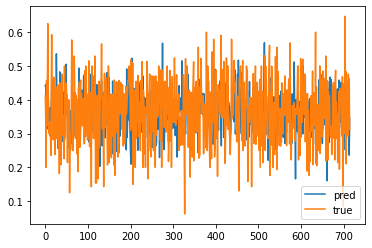

In [ ]:
import statsmodels.api as sm

fit_train = sm.OLS(train_y,train_x)
fit_train = fit_train.fit()

# 검증데이터에 대한 예측값과 true값 비교

plt.plot(np.array(fit_train.predict(test_x)),label = "pred")
plt.plot(np.array(test_y),label = "true")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_true = test_y, y_pred = fit_train.predict(test_x))
print('mse는', mse)
print('rmse는', np.sqrt(mse))

mse는 0.011224775528252908
rmse는 0.10594704114911803


### **Feature selection (SelectFromModel)**

In [ ]:
#불필요한 변수 제외
X = new_total_train_df.loc[:, ['tb', 'rbi', 'sb', 'sh', 'sf', 'ibb', 'WPA', 'avg', 'obp', 'slg', 'ops', 'power_barrel', 'contact_barrel', 'clutch_barrel', 'xh', 'babib', 'pitch/pa', 'cq', 'b/k', 'IsoP', 'IsoD', 'hr%', 'kk%', 'bb%', 'xh/h', 'ueqr','wOBA', 'ops_mean', 'avg_mean', 'obp_mean', 'slg_mean', 'power_barrel_mean', 'contact_barrel_mean', 'clutch_barrel_mean']]
y = new_total_train_df.loc[:, ['ops_label']]

In [ ]:
from sklearn.ensemble import RandomForestRegressor

etc_model = RandomForestRegressor()
etc_model.fit(X, y)

print(etc_model.feature_importances_)
feature_list = pd.concat([pd.Series(X.columns), pd.Series(etc_model.feature_importances_)], axis=1)
feature_list.columns = ['features_name', 'importance']
feature_list.sort_values("importance", ascending = False)[:15]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


[0.01583443 0.04166416 0.02926549 0.0177531  0.03163834 0.01419821
 0.02869412 0.01928444 0.02004522 0.01341109 0.01025824 0.03284958
 0.04925739 0.02544926 0.02094533 0.03188216 0.04414197 0.01931827
 0.03178044 0.02250561 0.03309005 0.01056652 0.03581225 0.03321884
 0.0247353  0.02159462 0.02558247 0.01345127 0.01399851 0.13142153
 0.02632277 0.01997592 0.01018124 0.01017283 0.01698387 0.01135578
 0.00794603 0.00696205 0.00716123 0.00964224 0.0096478 ]


,features_name,importance
29,ops_mean,0.131422
12,contact_barrel,0.049257
16,pitch/pa,0.044142
1,rbi,0.041664
22,kk%,0.035812
23,bb%,0.033219
20,IsoD,0.033090
11,power_barrel,0.032850
15,babib,0.031882
18,b/k,0.031780


In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

etc_model = ExtraTreesRegressor()
etc_model.fit(X, y)

print(etc_model.feature_importances_)
feature_list = pd.concat([pd.Series(X.columns), pd.Series(etc_model.feature_importances_)], axis=1)
feature_list.columns = ['features_name', 'importance']
feature_list.sort_values("importance", ascending = False)[:15]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


[0.02107123 0.02999009 0.02714614 0.0257374  0.02955702 0.02189971
 0.03266293 0.02201866 0.02315486 0.02019403 0.01970356 0.04067575
 0.03414499 0.03734906 0.02380795 0.02466042 0.0285571  0.02282614
 0.02526762 0.02138317 0.02688416 0.02680394 0.02865803 0.02570527
 0.02530745 0.01945142 0.01986527 0.08104647 0.02970101 0.03407019
 0.05230854 0.03464188 0.0223128  0.04143574]


,features_name,importance
27,ops_mean,0.081046
30,slg_mean,0.052309
33,clutch_barrel_mean,0.041436
11,power_barrel,0.040676
13,clutch_barrel,0.037349
31,power_barrel_mean,0.034642
12,contact_barrel,0.034145
29,obp_mean,0.034070
6,WPA,0.032663
1,rbi,0.029990


### **try scatter plot but..**

In [ ]:
home_data_1_2021 = first_pre(home_2021)
away_data_1_2021 = first_pre(away_2021)

In [ ]:
home_data_2_2021 = cal_feature(home_data_1_2021)
away_data_2_2021 = cal_feature(away_data_1_2021)

In [ ]:
home_data_3_2021 = make_percentage(home_data_2_2021)
away_data_3_2021 = make_percentage(away_data_2_2021)

In [ ]:
#period = 50 / interval = 7 / del_cri = 8로 정한 탐색할 2021시즌 홈 데이터
home_data_3_2021

,ab,score,hit,2_hit,3_hit,homerun,tb,rbi,sb,cs,bb,hpp,ibb,so,gdp,sh,sf,pitch,WPA,power_barrel,contact_barrel,clutch_barrel,PCODE,NAME,avg_label,slg_label,obp_label,ops_label,avg,obp,slg,ops,pa,1_hit,xh,babib,pitch/pa,cq,b/k,IsoP,IsoD,psn,hr%,kk%,bb%,xh/ab,xh/h,hr/xh,pa/hr,ab/hr,ueqr,wOBA
0,70,8,0.214286,0.047619,0,0.0238095,0.333333,0.166667,0,0,0.119048,0,0.0119048,0.0833333,0.0119048,0,0.047619,330,0.00786905,0.178571,0.0714286,0.0595238,76290,김현수,0.368421,0.473684,0.428571,0.902256,0.257143,0.333333,0.4,0.733333,84,0.142857,0.0714286,0.246,3.93,0.276,1.429,0.142857,0.0761905,0.000,0.024,0.083,0.119,0.071,0.333,0.333,42.0,35.0,0.768,0.324
1,33,2,0.179487,0.025641,0,0,0.205128,0.025641,0.025641,0,0.128205,0,0,0.0769231,0.0512821,0.025641,0.025641,131,-0.00174359,0,0.0512821,0,76802,김성현,0.2,0.2,0.428571,0.628571,0.212121,0.307692,0.242424,0.550117,39,0.153846,0.025641,0.226,3.36,0.197,1.667,0.030303,0.0955711,0.000,0.000,0.077,0.128,0.026,0.143,0.000,0.0,0.0,0.634,0.263
2,59,13,0.298507,0.0746269,0,0.0149254,0.41791,0.134328,0.0298507,0.0149254,0.0746269,0.0149254,0,0.179104,0,0,0.0447761,279,0.00244776,0.0149254,0.104478,0,64006,심우준,0.363636,0.590909,0.416667,1.00758,0.338983,0.382353,0.474576,0.856929,67,0.208955,0.0895522,0.388,4.16,0.391,0.417,0.135593,0.0433699,1.333,0.015,0.179,0.075,0.090,0.300,0.167,67.0,59.0,0.887,0.375
3,37,9,0.27907,0.0697674,0,0.0465116,0.488372,0.186047,0.0232558,0,0.116279,0.0465116,0,0.27907,0,0.0465116,0.0232558,199,0.0131395,0.116279,0.0465116,0,79365,박동원,0.25,0.375,0.368421,0.743421,0.324324,0.422222,0.567568,0.98979,43,0.162791,0.116279,0.417,4.63,0.492,0.417,0.243243,0.0978979,1.333,0.047,0.279,0.116,0.116,0.417,0.400,21.5,18.5,1.000,0.442
4,50,3,0.192308,0.115385,0,0,0.307692,0.0384615,0,0,0.0384615,0,0,0.173077,0.0769231,0,0,202,-0.0124231,0.0769231,0.115385,0,76812,이재원,0.142857,0.142857,0.2,0.342857,0.2,0.230769,0.32,0.550769,52,0.0769231,0.115385,0.244,3.88,0.239,0.222,0.12,0.0307692,0.000,0.000,0.173,0.038,0.115,0.600,0.000,0.0,0.0,0.558,0.240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,42,9,0.354167,0.0208333,0,0.0625,0.5625,0.25,0,0,0.125,0,0,0.166667,0,0,0,192,0.013875,0.0833333,0.125,0,62931,노진혁,0.444444,0.592593,0.464286,1.05688,0.404762,0.479167,0.642857,1.12202,48,0.270833,0.0833333,0.452,4.00,0.488,0.750,0.238095,0.0744048,0.000,0.062,0.167,0.125,0.083,0.235,0.750,16.0,14.0,1.104,0.481
294,59,6,0.28125,0.03125,0,0,0.3125,0.078125,0,0.015625,0.078125,0,0.015625,0.078125,0.015625,0.015625,0,197,0.00878125,0.046875,0.15625,0,64984,김태진,0.304348,0.391304,0.392857,0.784161,0.305085,0.359375,0.338983,0.698358,64,0.25,0.03125,0.333,3.08,0.278,1.000,0.0338983,0.0542903,0.000,0.000,0.078,0.078,0.031,0.111,0.000,0.0,0.0,0.697,0.325
295,44,10,0.431373,0.0196078,0,0.0196078,0.509804,0.0784314,0,0,0.117647,0.0196078,0,0.0392157,0.0392157,0,0.0196078,233,0.00376471,0.0392157,0.176471,0,61404,김헌곤,0.333333,0.466667,0.375,0.841667,0.5,0.557692,0.590909,1.1486,51,0.392157,0.0392157,0.500,4.57,0.448,3.000,0.0909091,0.0576923,0.000,0.020,0.039,0.118,0.039,0.091,0.500,51.0,44.0,1.144,0.515
296,54,15,0.316667,0,0,0.1,0.616667,0.25,0.0166667,0,0.1,0.0333333,0,0.216667,0.0166667,0,0,246,0.01375,0.133333,0.133333,0.0833333,62947,나성범,0.333333,0.428571,0.348837,0.777409,0.351852,0.435484,0.685185,1.12067,60,0.216667,0.1,0.371,4.10,0.502,0.462,0.333333,0.083632,1.714,0.100,0.217,0.100,0.100,0.316,1.000,10.0,9.0,1.103,0.487


In [ ]:
home_data_4_2021 = home_data_3_2021[home_data_3_2021['ab']>30]
home_data_4_2021

,ab,score,hit,2_hit,3_hit,homerun,tb,rbi,sb,cs,bb,hpp,ibb,so,gdp,sh,sf,pitch,WPA,power_barrel,contact_barrel,clutch_barrel,PCODE,NAME,avg_label,slg_label,obp_label,ops_label,avg,obp,slg,ops,pa,1_hit,xh,babib,pitch/pa,cq,b/k,IsoP,IsoD,psn,hr%,kk%,bb%,xh/ab,xh/h,hr/xh,pa/hr,ab/hr,ueqr,wOBA
0,70,8,0.214286,0.047619,0,0.0238095,0.333333,0.166667,0,0,0.119048,0,0.0119048,0.0833333,0.0119048,0,0.047619,330,0.00786905,0.178571,0.0714286,0.0595238,76290,김현수,0.368421,0.473684,0.428571,0.902256,0.257143,0.333333,0.4,0.733333,84,0.142857,0.0714286,0.246,3.93,0.276,1.429,0.142857,0.0761905,0.000,0.024,0.083,0.119,0.071,0.333,0.333,42.0,35.0,0.768,0.324
1,33,2,0.179487,0.025641,0,0,0.205128,0.025641,0.025641,0,0.128205,0,0,0.0769231,0.0512821,0.025641,0.025641,131,-0.00174359,0,0.0512821,0,76802,김성현,0.2,0.2,0.428571,0.628571,0.212121,0.307692,0.242424,0.550117,39,0.153846,0.025641,0.226,3.36,0.197,1.667,0.030303,0.0955711,0.000,0.000,0.077,0.128,0.026,0.143,0.000,0.0,0.0,0.634,0.263
2,59,13,0.298507,0.0746269,0,0.0149254,0.41791,0.134328,0.0298507,0.0149254,0.0746269,0.0149254,0,0.179104,0,0,0.0447761,279,0.00244776,0.0149254,0.104478,0,64006,심우준,0.363636,0.590909,0.416667,1.00758,0.338983,0.382353,0.474576,0.856929,67,0.208955,0.0895522,0.388,4.16,0.391,0.417,0.135593,0.0433699,1.333,0.015,0.179,0.075,0.090,0.300,0.167,67.0,59.0,0.887,0.375
3,37,9,0.27907,0.0697674,0,0.0465116,0.488372,0.186047,0.0232558,0,0.116279,0.0465116,0,0.27907,0,0.0465116,0.0232558,199,0.0131395,0.116279,0.0465116,0,79365,박동원,0.25,0.375,0.368421,0.743421,0.324324,0.422222,0.567568,0.98979,43,0.162791,0.116279,0.417,4.63,0.492,0.417,0.243243,0.0978979,1.333,0.047,0.279,0.116,0.116,0.417,0.400,21.5,18.5,1.000,0.442
4,50,3,0.192308,0.115385,0,0,0.307692,0.0384615,0,0,0.0384615,0,0,0.173077,0.0769231,0,0,202,-0.0124231,0.0769231,0.115385,0,76812,이재원,0.142857,0.142857,0.2,0.342857,0.2,0.230769,0.32,0.550769,52,0.0769231,0.115385,0.244,3.88,0.239,0.222,0.12,0.0307692,0.000,0.000,0.173,0.038,0.115,0.600,0.000,0.0,0.0,0.558,0.240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,42,9,0.354167,0.0208333,0,0.0625,0.5625,0.25,0,0,0.125,0,0,0.166667,0,0,0,192,0.013875,0.0833333,0.125,0,62931,노진혁,0.444444,0.592593,0.464286,1.05688,0.404762,0.479167,0.642857,1.12202,48,0.270833,0.0833333,0.452,4.00,0.488,0.750,0.238095,0.0744048,0.000,0.062,0.167,0.125,0.083,0.235,0.750,16.0,14.0,1.104,0.481
294,59,6,0.28125,0.03125,0,0,0.3125,0.078125,0,0.015625,0.078125,0,0.015625,0.078125,0.015625,0.015625,0,197,0.00878125,0.046875,0.15625,0,64984,김태진,0.304348,0.391304,0.392857,0.784161,0.305085,0.359375,0.338983,0.698358,64,0.25,0.03125,0.333,3.08,0.278,1.000,0.0338983,0.0542903,0.000,0.000,0.078,0.078,0.031,0.111,0.000,0.0,0.0,0.697,0.325
295,44,10,0.431373,0.0196078,0,0.0196078,0.509804,0.0784314,0,0,0.117647,0.0196078,0,0.0392157,0.0392157,0,0.0196078,233,0.00376471,0.0392157,0.176471,0,61404,김헌곤,0.333333,0.466667,0.375,0.841667,0.5,0.557692,0.590909,1.1486,51,0.392157,0.0392157,0.500,4.57,0.448,3.000,0.0909091,0.0576923,0.000,0.020,0.039,0.118,0.039,0.091,0.500,51.0,44.0,1.144,0.515
296,54,15,0.316667,0,0,0.1,0.616667,0.25,0.0166667,0,0.1,0.0333333,0,0.216667,0.0166667,0,0,246,0.01375,0.133333,0.133333,0.0833333,62947,나성범,0.333333,0.428571,0.348837,0.777409,0.351852,0.435484,0.685185,1.12067,60,0.216667,0.1,0.371,4.10,0.502,0.462,0.333333,0.083632,1.714,0.100,0.217,0.100,0.100,0.316,1.000,10.0,9.0,1.103,0.487


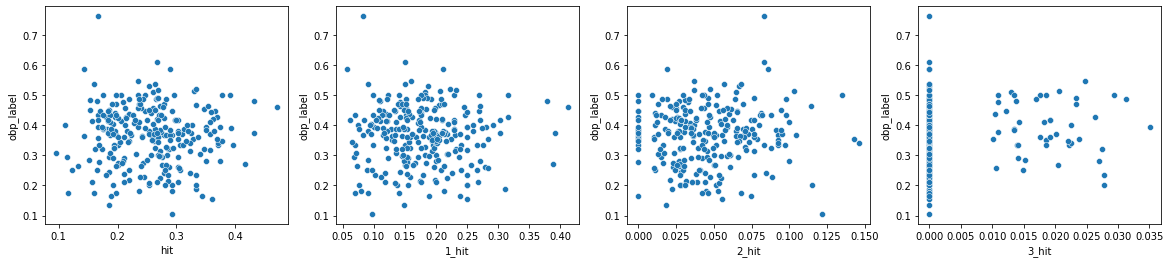

In [ ]:
#타석당 총 안타 / 1루타 / 2루타 / 3루타와 예측 출루율과의 산점도
fig  = plt.figure(figsize = (20,4))

area1 = fig.add_subplot(1,4,1)
area2 = fig.add_subplot(1,4,2)
area3 = fig.add_subplot(1,4,3)
area4 = fig.add_subplot(1,4,4)

sns.scatterplot(x='hit', y='obp_label', data = home_data_4_2021, ax = area1)
sns.scatterplot(x='1_hit', y='obp_label', data = home_data_4_2021, ax = area2)
sns.scatterplot(x='2_hit', y='obp_label', data = home_data_4_2021, ax = area3)
sns.scatterplot(x='3_hit', y='obp_label', data = home_data_4_2021, ax = area4)

plt.show()

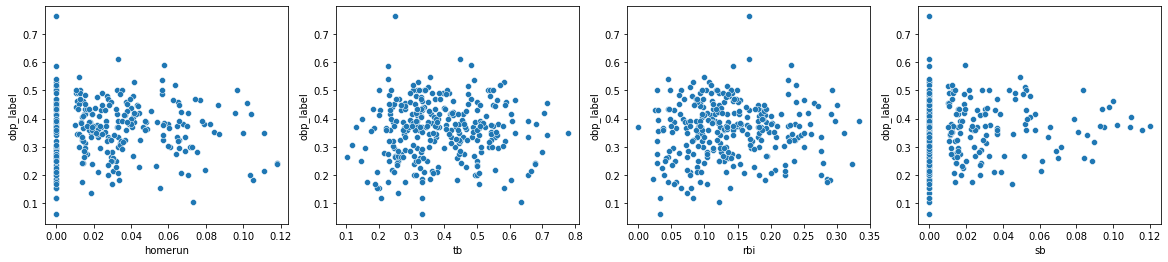

In [ ]:
#타석당 홈런 / 총 루타 / 타점 / 도루와 예측 출루율과의 산점도
fig  = plt.figure(figsize = (20,4))

area1 = fig.add_subplot(1,4,1)
area2 = fig.add_subplot(1,4,2)
area3 = fig.add_subplot(1,4,3)
area4 = fig.add_subplot(1,4,4)

sns.scatterplot(x='homerun', y='obp_label', data = home_data_3_2021, ax = area1)
sns.scatterplot(x='tb', y='obp_label', data = home_data_3_2021, ax = area2)
sns.scatterplot(x='rbi', y='obp_label', data = home_data_3_2021, ax = area3)
sns.scatterplot(x='sb', y='obp_label', data = home_data_3_2021, ax = area4)

plt.show()

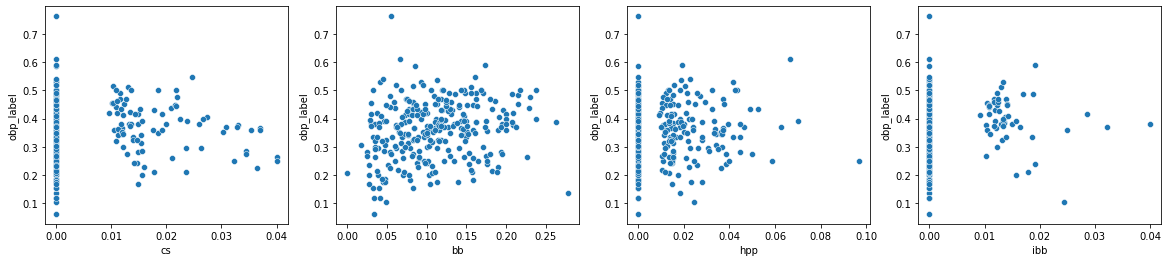

In [ ]:
#타석당 도루실패 / 볼넷 / 몸에맞는볼 / 고의4구와 예측 출루율과의 산점도
fig  = plt.figure(figsize = (20,4))

area1 = fig.add_subplot(1,4,1)
area2 = fig.add_subplot(1,4,2)
area3 = fig.add_subplot(1,4,3)
area4 = fig.add_subplot(1,4,4)

sns.scatterplot(x='cs', y='obp_label', data = home_data_3_2021, ax = area1)
sns.scatterplot(x='bb', y='obp_label', data = home_data_3_2021, ax = area2)
sns.scatterplot(x='hpp', y='obp_label', data = home_data_3_2021, ax = area3)
sns.scatterplot(x='ibb', y='obp_label', data = home_data_3_2021, ax = area4)

plt.show()

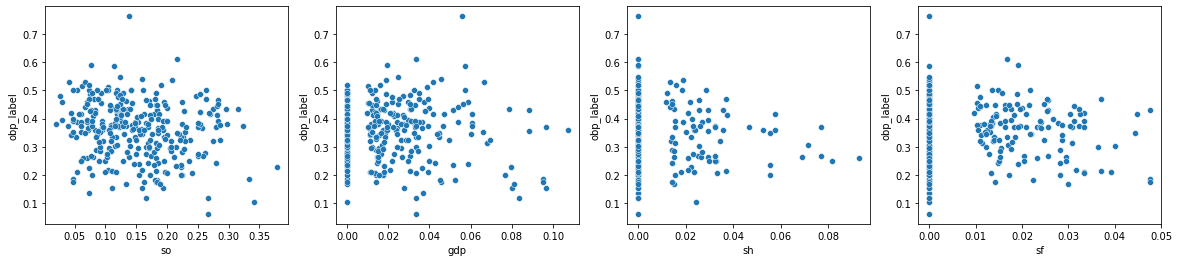

In [ ]:
#타석당 삼진 / 병살타 / 희생번트 / 희생플라이와 예측 출루율과의 산점도
fig  = plt.figure(figsize = (20,4))

area1 = fig.add_subplot(1,4,1)
area2 = fig.add_subplot(1,4,2)
area3 = fig.add_subplot(1,4,3)
area4 = fig.add_subplot(1,4,4)

sns.scatterplot(x='so', y='obp_label', data = home_data_3_2021, ax = area1)
sns.scatterplot(x='gdp', y='obp_label', data = home_data_3_2021, ax = area2)
sns.scatterplot(x='sh', y='obp_label', data = home_data_3_2021, ax = area3)
sns.scatterplot(x='sf', y='obp_label', data = home_data_3_2021, ax = area4)

plt.show()

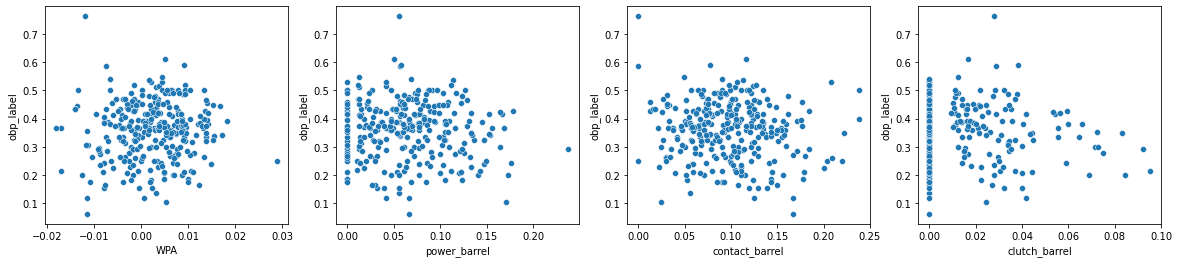

In [ ]:
#타석당 WPA / 파워 배럴 / 컨택 배럴 / 클러치 배럴와 예측 출루율과의 산점도
fig  = plt.figure(figsize = (20,4))

area1 = fig.add_subplot(1,4,1)
area2 = fig.add_subplot(1,4,2)
area3 = fig.add_subplot(1,4,3)
area4 = fig.add_subplot(1,4,4)

sns.scatterplot(x='WPA', y='obp_label', data = home_data_3_2021, ax = area1)
sns.scatterplot(x='power_barrel', y='obp_label', data = home_data_3_2021, ax = area2)
sns.scatterplot(x='contact_barrel', y='obp_label', data = home_data_3_2021, ax = area3)
sns.scatterplot(x='clutch_barrel', y='obp_label', data = home_data_3_2021, ax = area4)

plt.show()

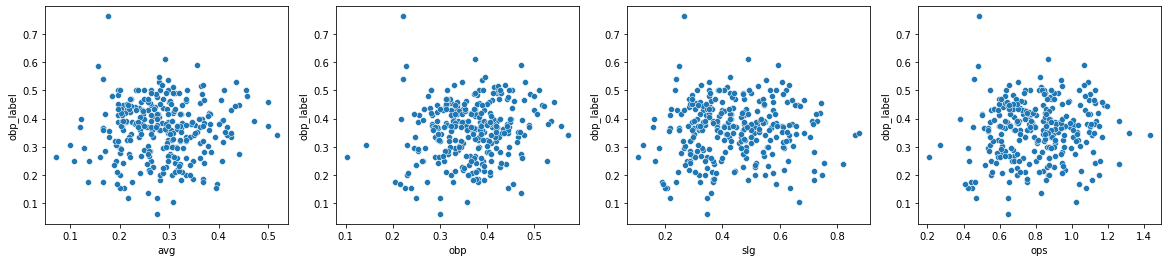

In [ ]:
# 타율 / 출루율 / 장타율 / OPS 와 예측 출루율과의 산점도
fig  = plt.figure(figsize = (20,4))

area1 = fig.add_subplot(1,4,1)
area2 = fig.add_subplot(1,4,2)
area3 = fig.add_subplot(1,4,3)
area4 = fig.add_subplot(1,4,4)

sns.scatterplot(x='avg', y='obp_label', data = home_data_3_2021, ax = area1)
sns.scatterplot(x='obp', y='obp_label', data = home_data_3_2021, ax = area2)
sns.scatterplot(x='slg', y='obp_label', data = home_data_3_2021, ax = area3)
sns.scatterplot(x='ops', y='obp_label', data = home_data_3_2021, ax = area4)

plt.show()

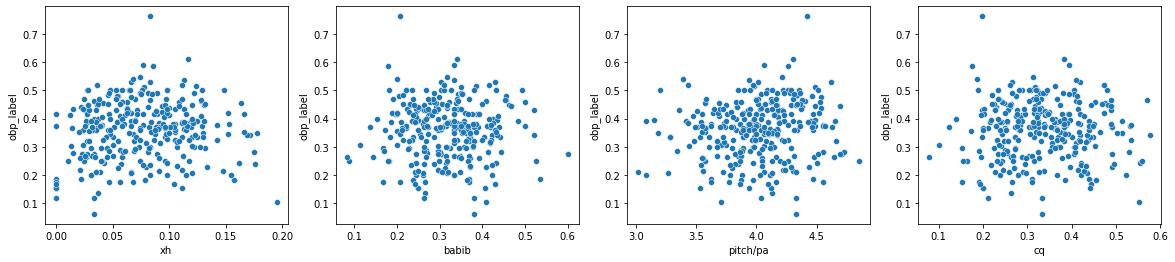

In [ ]:
#타석당 장타 / 바빕 / 투구수 / 컨택 퀄리티와 예측 출루율과의 산점도
fig  = plt.figure(figsize = (20,4))

area1 = fig.add_subplot(1,4,1)
area2 = fig.add_subplot(1,4,2)
area3 = fig.add_subplot(1,4,3)
area4 = fig.add_subplot(1,4,4)

sns.scatterplot(x='xh', y='obp_label', data = home_data_3_2021, ax = area1)
sns.scatterplot(x='babib', y='obp_label', data = home_data_3_2021, ax = area2)
sns.scatterplot(x='pitch/pa', y='obp_label', data = home_data_3_2021, ax = area3)
sns.scatterplot(x='cq', y='obp_label', data = home_data_3_2021, ax = area4)

plt.show()

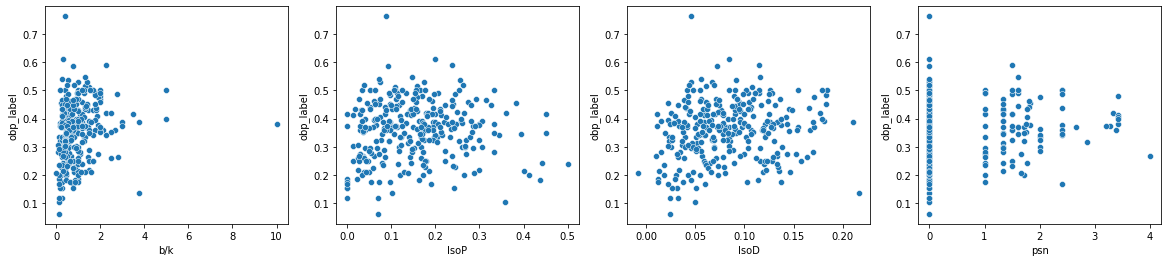

In [ ]:
#타석당 볼삼비 / 순장타율 / 순출루율 / 호타준족 수치와 예측 출루율과의 산점도
fig  = plt.figure(figsize = (20,4))

area1 = fig.add_subplot(1,4,1)
area2 = fig.add_subplot(1,4,2)
area3 = fig.add_subplot(1,4,3)
area4 = fig.add_subplot(1,4,4)

sns.scatterplot(x='b/k', y='obp_label', data = home_data_3_2021, ax = area1)
sns.scatterplot(x='IsoP', y='obp_label', data = home_data_3_2021, ax = area2)
sns.scatterplot(x='IsoD', y='obp_label', data = home_data_3_2021, ax = area3)
sns.scatterplot(x='psn', y='obp_label', data = home_data_3_2021, ax = area4)

plt.show()

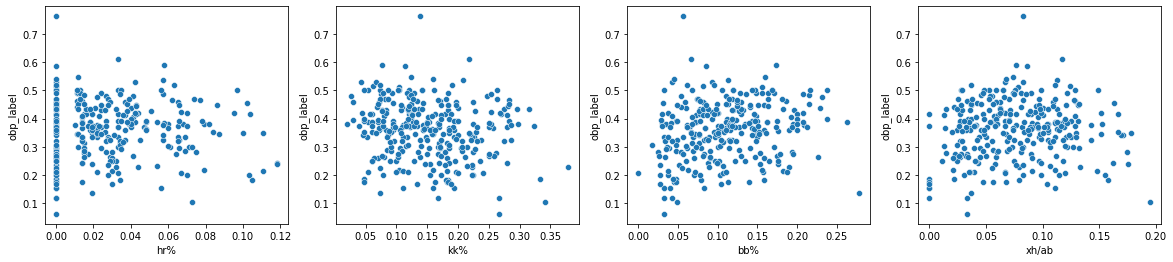

In [ ]:
#타석당 홈런 비율 / 삼진 비율 / 볼넷 비율 / 장타 비율과 예측 출루율과의 산점도
fig  = plt.figure(figsize = (20,4))

area1 = fig.add_subplot(1,4,1)
area2 = fig.add_subplot(1,4,2)
area3 = fig.add_subplot(1,4,3)
area4 = fig.add_subplot(1,4,4)

sns.scatterplot(x='hr%', y='obp_label', data = home_data_3_2021, ax = area1)
sns.scatterplot(x='kk%', y='obp_label', data = home_data_3_2021, ax = area2)
sns.scatterplot(x='bb%', y='obp_label', data = home_data_3_2021, ax = area3)
sns.scatterplot(x='xh/ab', y='obp_label', data = home_data_3_2021, ax = area4)

plt.show()

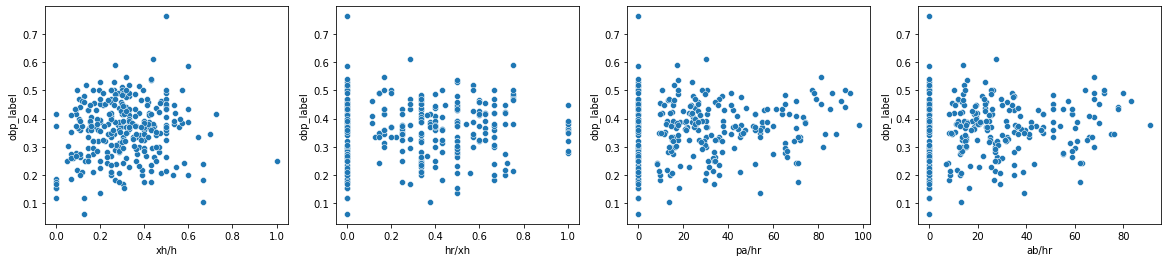

In [ ]:
#안타당 장타비율 / 장타당 홈런 비율 / 홈런 당 타석 / 홈런 당 타수와 예측 출루율과의 산점도
fig  = plt.figure(figsize = (20,4))

area1 = fig.add_subplot(1,4,1)
area2 = fig.add_subplot(1,4,2)
area3 = fig.add_subplot(1,4,3)
area4 = fig.add_subplot(1,4,4)

sns.scatterplot(x='xh/h', y='obp_label', data = home_data_3_2021, ax = area1)
sns.scatterplot(x='hr/xh', y='obp_label', data = home_data_3_2021, ax = area2)
sns.scatterplot(x='pa/hr', y='obp_label', data = home_data_3_2021, ax = area3)
sns.scatterplot(x='ab/hr', y='obp_label', data = home_data_3_2021, ax = area4)

plt.show()

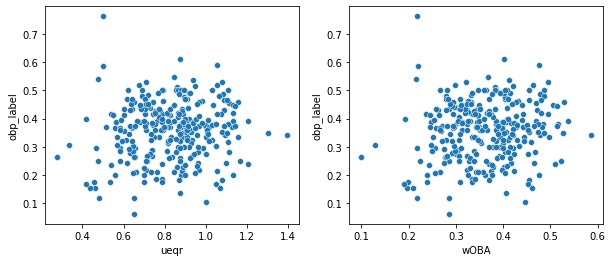

In [ ]:
#UEQR / wOBA와 예측 출루율과의 산점도
fig  = plt.figure(figsize = (10,4))

area1 = fig.add_subplot(1,2,1)
area2 = fig.add_subplot(1,2,2)

sns.scatterplot(x='ueqr', y='obp_label', data = home_data_3_2021, ax = area1)
sns.scatterplot(x='wOBA', y='obp_label', data = home_data_3_2021, ax = area2)

plt.show()

In [ ]:
home_data_3_2021.corrwith(home_data_3_2021['obp_label'], method='spearman')

babib      -0.031477
pitch/pa    0.148031
cq         -0.005370
b/k         0.262228
psn         0.077450
hr%         0.029268
kk%        -0.171062
bb%         0.212189
xh/ab       0.083189
xh/h        0.082447
hr/xh       0.074185
pa/hr       0.115187
ab/hr       0.105747
ueqr        0.078425
wOBA        0.094622
dtype: float64

In [ ]:
home_data_3_2021.corr(method='pearson')

,babib,pitch/pa,cq,b/k,psn,hr%,kk%,bb%,xh/ab,xh/h,hr/xh,pa/hr,ab/hr,ueqr,wOBA
babib,1.000000,0.081129,0.781135,0.001583,0.140997,0.064963,0.043431,-0.104755,0.295543,-0.189127,-0.085872,0.013350,0.020977,0.712497,0.728907
pitch/pa,0.081129,1.000000,0.087769,0.108331,0.208098,-0.016510,0.245949,0.451115,-0.029192,0.060590,0.115750,0.228993,0.203417,0.094941,0.139507
cq,0.781135,0.087769,1.000000,-0.112775,0.253348,0.644517,0.259388,-0.090510,0.719281,0.297526,0.370690,0.007130,0.013761,0.907134,0.876970
b/k,0.001583,0.108331,-0.112775,1.000000,-0.065135,-0.134778,-0.577262,0.620968,-0.188229,-0.201513,-0.018227,-0.026094,-0.060225,0.176753,0.253447
psn,0.140997,0.208098,0.253348,-0.065135,1.000000,0.226063,0.107409,0.145655,0.190622,0.118848,0.244000,0.307056,0.299816,0.300393,0.263412
hr%,0.064963,-0.016510,0.644517,-0.134778,0.226063,1.000000,0.241520,-0.068181,0.678080,0.529068,0.788146,-0.022763,-0.018094,0.614753,0.551432
kk%,0.043431,0.245949,0.259388,-0.577262,0.107409,0.241520,1.000000,-0.145062,0.239616,0.344497,0.234071,0.106906,0.118260,-0.090062,-0.110944
bb%,-0.104755,0.451115,-0.090510,0.620968,0.145655,-0.068181,-0.145062,1.000000,-0.124351,0.007602,0.091982,0.181055,0.123006,0.147319,0.226033
xh/ab,0.295543,-0.029192,0.719281,-0.188229,0.190622,0.678080,0.239616,-0.124351,1.000000,0.814937,0.290450,-0.000355,0.008435,0.666181,0.609960
xh/h,-0.189127,0.060590,0.297526,-0.201513,0.118848,0.529068,0.344497,0.007602,0.814937,1.000000,0.234063,0.014744,0.015349,0.242832,0.197667
